In [1]:
import pandas as pd
#pd.set_option('display.max_rows', None)
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib import path
import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import numpy as np
import netCDF4 as nc
np.set_printoptions(threshold=100000)
from shapely.geometry import Polygon, Point, MultiPoint
from shapely.ops import cascaded_union
from datetime import datetime, timedelta
import time
import warnings
import statsmodels.api as sm
import datetime
import math
from scipy.ndimage.interpolation import shift
import shapely.wkt
from scipy.stats import pearsonr,spearmanr,kendalltau
from scipy.optimize import curve_fit 

import seaborn as sns
sns.set(font_scale=2) 
from my_functions import sat_vap_press, vap_press, hot_dry_windy, haines

# Helper Functions

In [2]:
def plot_correlations(df_all, fig_title,correlation_type):
    #make the correlation matrix
    corrMatrix = df_all.corr(method=correlation_type)
    
    #plot it
    fig,ax=plt.subplots(figsize=(25,25))
    sns.heatmap(corrMatrix, annot=True,vmin=-1, vmax=1, cmap='seismic', annot_kws={'fontsize':35})
    plt.title(fig_title, fontsize=20)
    plt.show()

In [3]:
#plots two lines, on one or on the same axis
# IN: datax, x axis vector (time)
# IN: datay, 2*n vector of the data
# IN: linelabels, string vector of the labels of each line, to go in the legend
# IN: axis labels, labels of the axis
# IN: title, string for title of figire
# IN: twoaxis, if 1 plot data on two separate axes, else plot on the same axis
# OUT: a graph
def plot_twoline(datax, datay, title, linelabels, axislabels, twoaxis,xtickspacing):
    fig, ax = plt.subplots(figsize=(20,6)) #set up the figure
    if twoaxis==1:
        ax.plot(datax, datay[0,:], 'ro-') # plot the first line
        ax.set_ylabel(axislabels[0], fontsize=24, color='red')
        #ax.set_ylim(bottom=0,top = np.nanmax(datay))
        ax2=ax.twinx()
        ax2.plot(datax, datay[1,:], 'bo-') #plot the second line
        ax2.set_ylabel(axislabels[1], fontsize=24, color='blue')
        #ax2.set_ylim(bottom=0,top = np.nanmax(datay))
    else:
        ax.plot(datax, datay[0,:], 'ro-') # plot the first line
        ax.plot(datax, datay[1,:], 'bo-') # plot the second line
        ax.set_ylabel(axislabels, fontsize=24) 
    #print(np.arange(1,len(datax.values),6))
    plt.xticks(np.arange(1,len(datax.values),xtickspacing))    
    plt.legend(linelabels,fontsize=24)
    plt.title(title,fontsize=24)
    plt.grid()
    plt.show()


In [4]:
#IN df_to_shift: the dataframe we want to shift
#IN ndays: how many days we want to shift, ndays>0 shift forward, ndays<0 shift backward
def shift_ndays(df_to_shift,ndays,name_col_to_shift, name_shifted_col):
    df_shifted = df_to_shift.set_index(pd.to_datetime(df_to_shift['day'])).drop(columns=['day'])
    df_shifted=df_shifted.resample('24H',origin='start').asfreq()
    #process some daily changes in FRP
    for ii in range(len(name_shifted_col)):
        df_shifted[name_shifted_col[ii]] = df_shifted[name_col_to_shift[ii]].shift(ndays)
    inds = df_shifted.index.isin(df_to_shift['day'])
    return df_shifted[inds].reset_index()

In [5]:
def scatter_plot(df_plot,x_plot,y_plot,point_hue, point_style, point_size, point_size_range,plot_title):
    fig,ax=plt.subplots(figsize=(10,10))
    sns.scatterplot(data =df_plot, x=x_plot,y=y_plot,hue=point_hue,style=point_style,size=point_size,sizes=point_size_range,ax=ax)
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    plt.title(plot_title)
    plt.show()

# Jan 23rd Update

In [ ]:
rave_all = pd.DataFrame()
hrrr_all = pd.DataFrame()
names_all = pd.DataFrame()
days_all = pd.DataFrame()

fire_incidents = ['AUGUST COMPLEX', 'BOBCAT', 'DOLAN','CREEK', 'LAKE'] #only california ones
#fire_incidents =['AUGUST COMPLEX']
path_features='/data2/lthapa/ML_daily/fire_features/'
path_poly = '/data2/lthapa/ML_daily/fire_polygons/'
suffix_poly = 'Z_day_start.geojson'
start_time=12
for ii in range(len(fire_incidents)):
    file_prefix = fire_incidents[ii].lower().replace(' ', '_')
    print(file_prefix)
    
    #load in the data that needs variables shifted for persistence
    rave = pd.read_csv(path_features+file_prefix+'_SubDaily_RAVE_'+str(start_time)+'Z_day_start_Chen.csv')
    hrrr_directional = pd.read_csv(path_features+file_prefix+'_SubDaily_HRRR_Directional_'+str(start_time)+'Z_day_start_Chen.csv')
    names = pd.DataFrame({'name':[fire_incidents[ii]]*len(rave)})

    days_all = pd.concat([days_all,rave[['day']]],axis=0)
    names_all = pd.concat([names_all,names],axis=0)
    hrrr_all = pd.concat([hrrr_all, hrrr_directional.drop(columns=['Unnamed: 0', 'day'])])
    rave_all = pd.concat([rave_all,rave[['Mean_FRP']]],axis=0)
    
    features = pd.concat([days_all,
                         names_all,
                         hrrr_all,
                         rave_all],axis=1)
print(features)

In [ ]:
#jan 23 Update Plots
fire_incidents = ['AUGUST COMPLEX', 'BOBCAT', 'DOLAN','CREEK', 'LAKE'] #only california ones

for ii in range(len(fire_incidents)):
    print(fire_incidents[ii])
    features_plot = features[features['name']==fire_incidents[ii]]
    fig, ax = plt.subplots(figsize=(20,15)) 
    features_plot.plot(x='day', y=['hd0w0','hd0w0_edge','hd0w0_edge_lw',
                                       'hd0w0_perp',  'hd0w0_perp_lw', 'hd0w0_perp_out', 'hd0w0_perp_out_lw'],
                            figsize=(20,6),style='o-',ax=ax )
    features_plot.plot(x='day', y=['Mean_FRP'], secondary_y=True,
                            figsize=(20,6),style='ko-',ax=ax )
    plt.show()
    #df.plot(x = 'day', y = 'temp', ax = ax) 
    #df.plot(x = 'day', y = 'humidity', ax = ax, secondary_y = True) 

In [ ]:
plot_correlations(features, 'HRRR MET','pearson')


In [ ]:
fire_incidents = ['AUGUST COMPLEX', 'BOBCAT', 'DOLAN','CREEK', 'LAKE'] #only california ones

for ii in range(len(fire_incidents)):
    print(fire_incidents[ii])
    features_plot = features[features['name']==fire_incidents[ii]]
    plot_correlations(features_plot, 'HRRR MET '+fire_incidents[ii],'pearson')

    plt.show()


# Jan 30th Update Plot

In [ ]:
rave_all = pd.DataFrame()
hrrr_all = pd.DataFrame()
names_all = pd.DataFrame()
days_all = pd.DataFrame()
resources_all = pd.DataFrame()

fire_incidents = ['AUGUST COMPLEX', 'BOBCAT', 'DOLAN','CREEK', 'LAKE'] #only california ones
#fire_incidents =['LAKE']
path_features='/data2/lthapa/ML_daily/fire_features/'
path_poly = '/data2/lthapa/ML_daily/fire_polygons/'
suffix_poly = 'Z_day_start.geojson'
start_time=12
for ii in range(len(fire_incidents)):
    file_prefix = fire_incidents[ii].lower().replace(' ', '_')
    print(file_prefix)
    
    #load in the data that needs variables shifted for persistence
    rave = pd.read_csv(path_features+file_prefix+'_SubDaily_RAVE_'+str(start_time)+'Z_day_start_Chen.csv')
    hrrr_directional = pd.read_csv(path_features+file_prefix+'_SubDaily_HRRR_Directional_'+str(start_time)+'Z_day_start_Chen.csv')
    names = pd.DataFrame({'name':[fire_incidents[ii]]*len(rave)})
    resources = pd.read_csv(path_features+file_prefix+'_Daily_Resources_'+str(start_time)+'Z_day_start.csv')
    
    #set day (as a datetime64) to do manipulations later
    rave['day'] = np.array(rave['day'].values,dtype='datetime64')
    rave = rave.set_index('day')
    resources['day'] = np.array(resources['day'].values,dtype='datetime64')
    resources = resources.set_index('day')
    hrrr_directional['day'] = np.array(hrrr_directional['day'], dtype='datetime64')
    hrrr_directional = hrrr_directional.set_index('day')
    
    #get persisence
    rave['Yesterday_Mean_FRP'] = rave['Mean_FRP'].shift(periods=2)
    hrrr_directional['Yesterday_dhd0w0'] = hrrr_directional['hd0w0_perp_out_lw'].shift(periods=2)
    hrrr_directional['Yesterday_hd0w0'] = hrrr_directional['hd0w0'].shift(periods=2)
    #interpolate resources to sub-daily
    resources= resources.reindex(rave.index, method='nearest')
    resources['Yesterday_Percent_Contained'] = resources['percent_contained'].shift(periods=2)
    
    #reset the indices
    rave=rave.reset_index()
    resources = resources.reset_index()
    hrrr_directional = hrrr_directional.reset_index()

    days_all = pd.concat([days_all,rave[['day']]],axis=0)
    names_all = pd.concat([names_all,names],axis=0)
    hrrr_all = pd.concat([hrrr_all, hrrr_directional.drop(columns=['Unnamed: 0', 'day'])])
    resources_all = pd.concat([resources_all, resources[['Yesterday_Percent_Contained','percent_contained']]],axis=0)
    rave_all = pd.concat([rave_all,rave[['Yesterday_Mean_FRP','Mean_FRP']]],axis=0)
    
    features = pd.concat([days_all,
                         names_all,
                         hrrr_all,
                         resources_all,
                         rave_all],axis=1)
print(features.iloc[100:110])

In [ ]:
# additional feature processing (adding containment, persistence)
features['cont_dhd0w0'] = (1-(features['percent_contained']/100))*features['hd0w0_perp_out_lw']
features['cont1_dhd0w0'] =(1-(features['Yesterday_Percent_Contained']/100))*features['hd0w0_perp_out_lw']
features['FRP_rel_dhd0w0'] = features['Yesterday_Mean_FRP']*features['hd0w0_perp_out_lw']/features['Yesterday_dhd0w0']
features['cont1_FRP1_rel_dhd0w0'] = (1-(features['Yesterday_Percent_Contained']/100))*features['Yesterday_Mean_FRP']*features['hd0w0_perp_out_lw']/features['Yesterday_dhd0w0']

In [ ]:
subdaily_poly = pd.DataFrame()
# additional feature processing (adding containment, persistence)
subdaily_poly['cont_hd0w0'] = (1-(features['percent_contained']/100))*features['hd0w0']
subdaily_poly['cont1_hd0w0'] =(1-(features['Yesterday_Percent_Contained']/100))*features['hd0w0']
subdaily_poly['FRP_rel_hd0w0'] = features['Yesterday_Mean_FRP']*features['hd0w0']/features['Yesterday_hd0w0']
subdaily_poly['cont1_FRP1_rel_hd0w0'] = (1-(features['Yesterday_Percent_Contained']/100))*features['Yesterday_Mean_FRP']*features['hd0w0']/features['Yesterday_hd0w0']
subdaily_poly['Mean_FRP'] = features['Mean_FRP']
subdaily_poly['Yesterday_Mean_FRP'] = features['Yesterday_Mean_FRP']
subdaily_poly['hd0w0'] = features['hd0w0']
subdaily_poly['day'] = features['day']
subdaily_poly['name'] = features['name']

In [ ]:
#Jan 30th Update Plots, time series of just the  
fire_incidents = ['AUGUST COMPLEX', 'BOBCAT', 'DOLAN','CREEK', 'LAKE'] #only california ones

for ii in range(len(fire_incidents)):
    print(fire_incidents[ii])
    features_plot = features[features['name']==fire_incidents[ii]]
    fig, ax = plt.subplots(figsize=(20,15)) 
    features_plot.plot(x='day', y=['hd0w0_perp_out', 'hd0w0_perp_out_lw'],
                            figsize=(20,6),style='o-',ax=ax )
    features_plot.plot(x='day', y=['Mean_FRP'], secondary_y=True,
                            figsize=(20,6),style='ko-',ax=ax )
    plt.show()
    #df.plot(x = 'day', y = 'temp', ax = ax) 
    #df.plot(x = 'day', y = 'humidity', ax = ax, secondary_y = True) 

In [ ]:
#Jan 30th Update Plots, time series of just the  
fire_incidents = ['AUGUST COMPLEX', 'BOBCAT', 'DOLAN','CREEK', 'LAKE'] #only california ones

for ii in range(len(fire_incidents)):
    print(fire_incidents[ii])
    features_plot = features[features['name']==fire_incidents[ii]]
    fig, ax = plt.subplots(figsize=(20,15)) 
    features_plot.plot(x='day', y=['hd0w0_perp_out_lw','cont_dhd0w0','cont1_dhd0w0'],
                            figsize=(20,6),style='o-',ax=ax )
    features_plot.plot(x='day', y=['Mean_FRP'], secondary_y=True,
                            figsize=(20,6),style='ko-',ax=ax )
    plt.show()
    #df.plot(x = 'day', y = 'temp', ax = ax) 
    #df.plot(x = 'day', y = 'humidity', ax = ax, secondary_y = True) 

In [ ]:
#Jan 30th Update Plots, time series of just the  
fire_incidents = ['AUGUST COMPLEX', 'BOBCAT', 'DOLAN','CREEK', 'LAKE'] #only california ones

for ii in range(len(fire_incidents)):
    print(fire_incidents[ii])
    features_plot = features[features['name']==fire_incidents[ii]]
    fig, ax = plt.subplots(figsize=(20,15)) 
    features_plot.plot(x='day', y=['FRP_rel_dhd0w0','cont1_FRP1_rel_dhd0w0'],
                            figsize=(20,6),style='o-',ax=ax )
    features_plot.plot(x='day', y=['Mean_FRP'],
                            figsize=(20,6),style='ko-',ax=ax )
    plt.show()
    #df.plot(x = 'day', y = 'temp', ax = ax) 
    #df.plot(x = 'day', y = 'humidity', ax = ax, secondary_y = True) 

In [ ]:
fire_incidents = ['AUGUST COMPLEX', 'BOBCAT', 'DOLAN','CREEK', 'LAKE'] #only california ones

for ii in range(len(fire_incidents)):
    print(fire_incidents[ii])
    features_plot = features[features['name']==fire_incidents[ii]]
    fig, ax = plt.subplots(figsize=(20,15)) 
    features_plot.plot(x='day', y=['wind_speed'],
                            figsize=(20,6),style='o-',ax=ax )
    features_plot.plot(x='day', y=['vpd_2m'], secondary_y=True,
                            figsize=(20,6),style='ko-',ax=ax )
    plt.show()
    #df.plot(x = 'day', y = 'temp', ax = ax) 
    #df.plot(x = 'day', y = 'humidity', ax = ax, secondary_y = True) 


In [ ]:
#subdaily, whole polygon
features_noout = features[features['cont1_FRP1_rel_dhd0w0'].values<150000]
subdaily_poly_noout = subdaily_poly[subdaily_poly['cont1_FRP1_rel_hd0w0'].values<150000]

plot_correlations(subdaily_poly[['hd0w0', 'cont_hd0w0', 'cont1_hd0w0',
                            'FRP_rel_hd0w0', 'cont1_FRP1_rel_hd0w0',
                            'Yesterday_Mean_FRP','Mean_FRP']], 'HRRR MET','pearson')

plot_correlations(features[['hd0w0','hd0w0_perp_out_lw', 'cont_dhd0w0', 'cont1_dhd0w0',
                            'FRP_rel_dhd0w0', 'cont1_FRP1_rel_dhd0w0',
                            'Yesterday_Mean_FRP','Mean_FRP']], 'HRRR MET','pearson')

plot_correlations(subdaily_poly_noout[['hd0w0', 'cont_hd0w0', 'cont1_hd0w0',
                            'FRP_rel_hd0w0', 'cont1_FRP1_rel_hd0w0',
                            'Yesterday_Mean_FRP','Mean_FRP']], 'HRRR MET','pearson')

plot_correlations(features_noout[['hd0w0','hd0w0_perp_out_lw', 'cont_dhd0w0', 'cont1_dhd0w0',
                            'FRP_rel_dhd0w0', 'cont1_FRP1_rel_dhd0w0',
                            'Yesterday_Mean_FRP','Mean_FRP']], 'HRRR MET','pearson')

In [ ]:
fire_incidents = ['AUGUST COMPLEX', 'BOBCAT', 'DOLAN','CREEK', 'LAKE'] #only california ones

for ii in range(len(fire_incidents)):
    print(fire_incidents[ii])
    subdaily_poly_plot = subdaily_poly[features['name']==fire_incidents[ii]]
    fig, ax = plt.subplots(figsize=(20,15)) 
    subdaily_poly_plot.plot(x='day', y=['cont_hd0w0','cont1_hd0w0'],
                            figsize=(20,6),style='o-',ax=ax )
    subdaily_poly_plot.plot(x='day', y=['Mean_FRP'], secondary_y=True,
                            figsize=(20,6),style='ko-',ax=ax )
    plt.show()
    
    fig, ax = plt.subplots(figsize=(20,15)) 
    subdaily_poly_plot.plot(x='day', y=['FRP_rel_hd0w0','cont1_FRP1_rel_hd0w0', 'Yesterday_Mean_FRP'],
                            figsize=(20,6),style='o-',ax=ax )
    subdaily_poly_plot.plot(x='day', y=['Mean_FRP'], secondary_y=True,
                            figsize=(20,6),style='ko-',ax=ax )
    plt.show()

In [ ]:
#Subdaily, perp
features = features[features['cont1_FRP1_rel_dhd0w0'].values<150000]




In [ ]:
fire_incidents = ['AUGUST COMPLEX']#, 'BOBCAT', 'DOLAN','CREEK', 'LAKE'] #only california ones

for ii in range(len(fire_incidents)):
    print(fire_incidents[ii])
    features_plot = features[features['name']==fire_incidents[ii]]
    print(features_plot.iloc[44:45])

# Feb 6th Update, sub daily features

In [ ]:
#SUB DAILY FEATURES
rave_all = pd.DataFrame()
hrrr_directional_all = pd.DataFrame()
hrrr_directional_hourly_all = pd.DataFrame()
resources_all=pd.DataFrame()
names_all = pd.DataFrame()
days_all = pd.DataFrame()

fire_incidents = ['AUGUST COMPLEX', 'BOBCAT','CREEK', 'DOLAN','LAKE'] #only california ones
#fire_incidents =['AUGUST COMPLEX']
path_features='/data2/lthapa/ML_daily/fire_features/'
path_poly = '/data2/lthapa/ML_daily/fire_polygons/'
suffix_poly = 'Z_day_start.geojson'
start_time=12
for ii in range(len(fire_incidents)):
    file_prefix = fire_incidents[ii].lower().replace(' ', '_')
    print(file_prefix)
    
    #load in the data that needs variables shifted for persistence
    rave = pd.read_csv(path_features+file_prefix+'_SubDaily_RAVE_'+str(start_time)+'Z_day_start_Chen.csv')
    hrrr_directional_hourly = pd.read_csv(path_features+file_prefix+'Hourly_HRRR_Directional_12H_'+str(start_time)+'Z_day_start_Chen.csv')
    hrrr_directional = pd.read_csv(path_features+file_prefix+'_SubDaily_HRRR_Directional_'+str(start_time)+'Z_day_start_Chen.csv')
    names = pd.DataFrame({'name':[fire_incidents[ii]]*len(rave)})
    resources = pd.read_csv(path_features+file_prefix+'_Daily_Resources_'+str(start_time)+'Z_day_start.csv')

    print(rave['day'])
    print(hrrr_directional_hourly['day'])
    #set day (as a datetime64) to do manipulations later
    rave['day'] = np.array(rave['day'].values,dtype='datetime64')
    rave = rave.set_index('day')
    resources['day'] = np.array(resources['day'].values,dtype='datetime64')
    resources = resources.set_index('day')
    hrrr_directional['day'] = np.array(hrrr_directional['day'], dtype='datetime64')
    hrrr_directional = hrrr_directional.set_index('day')
    hrrr_directional_hourly['day'] = np.array(hrrr_directional_hourly['day'], dtype='datetime64')
    hrrr_directional_hourly = hrrr_directional_hourly.set_index('day')
    
    #get persisence
    rave['Yesterday_Mean_FRP'] = rave['Mean_FRP'].shift(periods=2)
    hrrr_directional['Yesterday_hd0w0'] = hrrr_directional['hd0w0'].shift(periods=2)
    hrrr_directional_hourly['Yesterday_dhd00w0'] = hrrr_directional_hourly['dhd00w0'].shift(periods=2)
    hrrr_directional_hourly['Yesterday_hwp'] = hrrr_directional_hourly['hwp'].shift(periods=2)
    hrrr_directional_hourly['Yesterday_dhwp'] = hrrr_directional_hourly['dhwp'].shift(periods=2)
    #interpolate resources to sub-daily
    resources= resources.reindex(rave.index, method='nearest')
    resources['Yesterday_Percent_Contained'] = resources['percent_contained'].shift(periods=2)
    
    #reset the indices
    rave=rave.reset_index()
    resources = resources.reset_index()
    hrrr_directional = hrrr_directional.reset_index()
    hrrr_directional_hourly = hrrr_directional_hourly.reset_index()


    days_all = pd.concat([days_all,rave[['day']]],axis=0)
    names_all = pd.concat([names_all,names],axis=0)
    hrrr_directional_all = pd.concat([hrrr_directional_all, hrrr_directional.drop(columns=['Unnamed: 0', 'day'])],axis=0)
    hrrr_directional_hourly_all = pd.concat([hrrr_directional_hourly_all, hrrr_directional_hourly.drop(columns=['Unnamed: 0', 'day'])],axis=0)
    rave_all = pd.concat([rave_all,rave[['Yesterday_Mean_FRP','Mean_FRP']]],axis=0)
    resources_all = pd.concat([resources_all, resources[['Yesterday_Percent_Contained','percent_contained']]],axis=0)

    
    features = pd.concat([days_all,
                         names_all,
                         hrrr_directional_all,
                         hrrr_directional_hourly_all,
                         resources_all,
                         rave_all],axis=1)
print(features.columns)

In [ ]:
#HD0W0 
features['cont1_hd0w0'] =(1-(features['Yesterday_Percent_Contained']/100))*features['hd0w0']
features['FRP_rel_hd0w0'] = features['Yesterday_Mean_FRP']*features['hd0w0']/features['Yesterday_hd0w0']
features['cont1_FRP1_rel_hd0w0'] = (1-(features['Yesterday_Percent_Contained']/100))*features['Yesterday_Mean_FRP']*features['hd0w0']/features['Yesterday_hd0w0']

#dHD0W0
features['cont1_dhd00w0'] =(1-(features['Yesterday_Percent_Contained']/100))*features['dhd00w0']
features['FRP_rel_dhd00w0'] = features['Yesterday_Mean_FRP']*features['dhd00w0']/features['Yesterday_dhd00w0']
features['cont1_FRP1_rel_dhd00w0'] = (1-(features['Yesterday_Percent_Contained']/100))*features['Yesterday_Mean_FRP']*features['dhd00w0']/features['Yesterday_dhd00w0']

#HWP
features['cont1_hwp'] =(1-(features['Yesterday_Percent_Contained']/100))*features['hwp']
features['FRP_rel_hwp'] = features['Yesterday_Mean_FRP']*features['hwp']/features['Yesterday_hwp']
features['cont1_FRP1_rel_hwp'] = (1-(features['Yesterday_Percent_Contained']/100))*features['Yesterday_Mean_FRP']*features['hwp']/features['Yesterday_hwp']

#dHWP 
features['cont1_dhwp'] =(1-(features['Yesterday_Percent_Contained']/100))*features['dhwp']
features['FRP_rel_dhwp'] = features['Yesterday_Mean_FRP']*features['dhwp']/features['Yesterday_dhwp']
features['cont1_FRP1_rel_dhwp'] = (1-(features['Yesterday_Percent_Contained']/100))*features['Yesterday_Mean_FRP']*features['dhwp']/features['Yesterday_dhwp']


features = features[features['cont1_FRP1_rel_dhwp']<500000]

In [ ]:
# does calculating dHDW hourly and then averaging improve things?
plot_correlations(features[['hd0w0','hd0w0_perp_out_lw','dhd00w0','Yesterday_Mean_FRP','Mean_FRP']], 
                  'All Fires, pearson','pearson')
plot_correlations(features[['hd0w0','hd0w0_perp_out_lw','dhd00w0','Yesterday_Mean_FRP','Mean_FRP']], 
                  'All Fires, spearman','spearman')
plot_correlations(features[['hd0w0','hd0w0_perp_out_lw','dhd00w0','Yesterday_Mean_FRP','Mean_FRP']], 
                  'All Fires, kendall','kendall')


In [ ]:
#HDW
plot_correlations(features[['hd0w0','cont1_hd0w0','FRP_rel_hd0w0','cont1_FRP1_rel_hd0w0','Yesterday_Mean_FRP','Mean_FRP']], 
                  'All Fires HD0W0, pearson','pearson')
plot_correlations(features[['hd0w0','cont1_hd0w0','FRP_rel_hd0w0','cont1_FRP1_rel_hd0w0','Yesterday_Mean_FRP','Mean_FRP']], 
                  'All Fires HD0W0, Spearman','spearman')
plot_correlations(features[['hd0w0','cont1_hd0w0','FRP_rel_hd0w0','cont1_FRP1_rel_hd0w0','Yesterday_Mean_FRP','Mean_FRP']], 
                  'All Fires HD0W0, Kendall','kendall')

#dHDW
plot_correlations(features[['dhd00w0','cont1_dhd00w0','FRP_rel_dhd00w0','cont1_FRP1_rel_dhd00w0','Yesterday_Mean_FRP','Mean_FRP']], 
                  'All Fires dHD00W0, pearson','pearson')
plot_correlations(features[['dhd00w0','cont1_dhd00w0','FRP_rel_dhd00w0','cont1_FRP1_rel_dhd00w0','Yesterday_Mean_FRP','Mean_FRP']], 
                  'All Fires dHD00W0, Spearman','spearman')
plot_correlations(features[['dhd00w0','cont1_dhd00w0','FRP_rel_dhd00w0','cont1_FRP1_rel_dhd00w0','Yesterday_Mean_FRP','Mean_FRP']], 
                  'All Fires dHD00W0, Kendall','kendall')
#HWP plots
plot_correlations(features[['hwp','cont1_hwp','FRP_rel_hwp','cont1_FRP1_rel_hwp','Yesterday_Mean_FRP','Mean_FRP']], 
                  'All Fires HWP, pearson','pearson')
plot_correlations(features[['hwp','cont1_hwp','FRP_rel_hwp','cont1_FRP1_rel_hwp','Yesterday_Mean_FRP','Mean_FRP']], 
                  'All Fires HWP, Spearman','spearman')
plot_correlations(features[['hwp','cont1_hwp','FRP_rel_hwp','cont1_FRP1_rel_hwp','Yesterday_Mean_FRP','Mean_FRP']], 
                  'All Fires HWP, Kendall','kendall')

#dHWP plots
plot_correlations(features[['dhwp','cont1_dhwp','FRP_rel_dhwp','cont1_FRP1_rel_dhwp','Yesterday_Mean_FRP','Mean_FRP']], 
                  'All Fires dHWP, pearson','pearson')
plot_correlations(features[['dhwp','cont1_dhwp','FRP_rel_dhwp','cont1_FRP1_rel_dhwp','Yesterday_Mean_FRP','Mean_FRP']], 
                  'All Fires dHWP, Spearman','spearman')
plot_correlations(features[['dhwp','cont1_dhwp','FRP_rel_dhwp','cont1_FRP1_rel_dhwp','Yesterday_Mean_FRP','Mean_FRP']], 
                  'All Fires dHWP, Kendall','kendall')

In [ ]:
for ii in range(len(fire_incidents)):
    print(fire_incidents[ii])
    features_plot = features[features['name']==fire_incidents[ii]]
    fig, ax = plt.subplots(figsize=(20,15)) 
    features_plot.plot(x='day', y=['cont1_FRP1_rel_hd0w0', 'cont1_FRP1_rel_dhd00w0','cont1_FRP1_rel_hwp','cont1_FRP1_rel_dhwp'],
                            figsize=(20,6),style='o-',ax=ax )
    features_plot.plot(x='day', y=['Mean_FRP'], secondary_y=True,
                            figsize=(20,6),style='ko-',ax=ax )
    plt.show()

In [ ]:
for ii in range(len(fire_incidents)):
    print(fire_incidents[ii])
    features_plot = features[features['name']==fire_incidents[ii]]
    fig, ax = plt.subplots(figsize=(20,15)) 
    features_plot.plot(x='day', y=['hwp','dhwp'],
                            figsize=(20,6),style='o-',ax=ax )
    features_plot.plot(x='day', y=['Mean_FRP'], secondary_y=True,
                            figsize=(20,6),style='ko-',ax=ax )
    plt.show()

In [ ]:
for ii in range(len(fire_incidents)):
    print(fire_incidents[ii])
    features_plot = features[features['name']==fire_incidents[ii]]
    fig, ax = plt.subplots(figsize=(20,15)) 
    features_plot.plot(x='day', y=['hd0w0','dhd00w0'],
                            figsize=(20,6),style='o-',ax=ax )
    features_plot.plot(x='day', y=['Mean_FRP'], secondary_y=True,
                            figsize=(20,6),style='ko-',ax=ax )
    plt.show()

In [ ]:
plot_correlations(features[['dhd00w0','dhd05w0','dhd10w0','dhd15w0','dhd20w0','dhd25w0','dhd30w0',
                            'Yesterday_Mean_FRP','Mean_FRP']], 
                  'All Fires, pearson','pearson')
plot_correlations(features[['dhd00w0','dhd05w0','dhd10w0','dhd15w0','dhd20w0','dhd25w0','dhd30w0',
                            'Yesterday_Mean_FRP','Mean_FRP']], 
                  'All Fires, spearman','spearman')
plot_correlations(features[['dhd00w0','dhd05w0','dhd10w0','dhd15w0','dhd20w0','dhd25w0','dhd30w0',
                            'Yesterday_Mean_FRP','Mean_FRP']], 
                  'All Fires, kendall','kendall')

In [ ]:
fire_incidents = ['AUGUST COMPLEX', 'BOBCAT','CREEK', 'LAKE'] #only california ones

for ii in range(len(fire_incidents)):
    print(fire_incidents[ii])
    features_plot = features[features['name']==fire_incidents[ii]]
    fig, ax = plt.subplots(figsize=(20,15)) 
    features_plot.plot(x='day', y=['hwp', 'dhwp'],
                            figsize=(20,6),style='o-',ax=ax )
    features_plot.plot(x='day', y=['Mean_FRP'], secondary_y=True,
                            figsize=(20,6),style='ko-',ax=ax )
    plt.show()

# Feb 6th Update, daily features

In [6]:
#DAILY FEATURES
features_all = pd.DataFrame()

fire_incidents = ['AUGUST COMPLEX', 'BOBCAT','CREEK', 'DOLAN','LAKE'] #only california ones
#fire_incidents =['LAKE']
path_features='/data2/lthapa/ML_daily/fire_features/'
path_poly = '/data2/lthapa/ML_daily/fire_polygons/'
suffix_poly = 'Z_day_start.geojson'
start_time=12
for ii in range(len(fire_incidents)):
    file_prefix = fire_incidents[ii].lower().replace(' ', '_')
    print(file_prefix)
    
    #load in the data that needs variables shifted for persistence
    #resources don't need to be resampled to daily, they are already daily
    resources = pd.read_csv(path_features+file_prefix+'_Daily_Resources_'+str(start_time)+'Z_day_start.csv')
    resources['day'] = np.array(resources['day'].values,dtype='datetime64')+np.timedelta64(start_time,'h') #add 12H so the inner join works

    #resample the sub-daily to daily
    rave = pd.read_csv(path_features+file_prefix+'_SubDaily_RAVE_'+str(start_time)+'Z_day_start_Chen.csv')
    rave['day'] =np.array(rave['day'].values,dtype='datetime64')
    rave = rave.set_index('day').resample('24H',offset='12H').sum().reset_index()
    rave.rename(columns={'Mean_FRP':'Sum_FRP'},inplace=True) #rename it because it 
    
    hrrr_directional = pd.read_csv(path_features+file_prefix+'_Hourly_HRRR_Directional_Daily_'+str(start_time)+'Z_day_start_Chen.csv')
    hrrr_directional['day'] =np.array(hrrr_directional['day'].values,dtype='datetime64')
    hrrr_directional = hrrr_directional.set_index('day').resample('24H',offset='12H').mean().reset_index()
    print(hrrr_directional['hd00w0'])
    #do the persistence
    rave_shifted = shift_ndays(rave,1,['Sum_FRP'],['Yesterday_Sum_FRP'])
    #directional ones
    hrrr_directional_shifted = shift_ndays(hrrr_directional,1,
                                           ['dhd00w0','dhd05w0','dhd10w0','dhd15w0','dhd20w0','dhd25w0','dhd30w0','dhwp'],
                                           ['Yesterday_dhd00w0','Yesterday_dhd05w0','Yesterday_dhd10w0',
                                            'Yesterday_dhd15w0','Yesterday_dhd20w0','Yesterday_dhd25w0',
                                            'Yesterday_dhd30w0','Yesterday_dhwp']) #directional
    
    hrrr_directional_shifted = shift_ndays(hrrr_directional_shifted,1,
                                           ['hd00w0','hd05w0','hd10w0','hd15w0','hd20w0','hd25w0','hd30w0','hwp'],
                                           ['Yesterday_hd00w0','Yesterday_hd05w0','Yesterday_hd10w0',
                                            'Yesterday_hd15w0','Yesterday_hd20w0','Yesterday_hd25w0',
                                            'Yesterday_hd30w0','Yesterday_hwp'])#whole polygon
 
    resources_shifted = shift_ndays(resources, 1,['percent_contained'],['Yesterday_percent_contained'])
    
        
    resampled_to_daily = pd.concat([hrrr_directional_shifted.drop(columns=['Unnamed: 0']), 
                                    rave_shifted[['Yesterday_Sum_FRP','Sum_FRP']]],axis=1)
    
    features = pd.merge(resampled_to_daily, resources_shifted, how='inner', on=['day'])
    
    #add in the names
    features['name'] = pd.DataFrame({'name':[fire_incidents[ii]]*len(features)})
    features_all = pd.concat([features_all, features],axis=0)

august_complex
0     140.276801
1     139.641668
2     151.413173
3     115.643915
4      68.707950
         ...    
57           NaN
58           NaN
59           NaN
60           NaN
61    126.667828
Name: hd00w0, Length: 62, dtype: float64
bobcat
0     198.402362
1     152.223992
2      85.857675
3     118.784643
4      59.815781
5      71.643508
6      70.751799
7      65.845181
8      74.365373
9      73.327577
10     82.077187
11    101.887253
12    159.851498
13    122.117754
14     91.661434
15     69.843933
16     56.257257
17     67.095243
18     62.211540
Name: hd00w0, dtype: float64
creek
0      97.505465
1     156.839242
2     146.228702
3     137.401130
4     157.081511
5      84.618039
6      65.124642
7      69.044664
8      82.579053
9      88.221257
10     96.658571
11     85.349538
12     70.501729
13     80.013860
14     44.468509
15     51.303693
16     55.594197
17     61.621628
18     55.680205
19     50.262126
20     47.584270
21     44.674217
22     55.910220
2

In [7]:
#additional processing for containment and persistence
feat_cont_pers = pd.DataFrame()
#HDW 
feat_cont_pers['cont1_FRP1_rel_hd00w0'] = (1-(features_all['Yesterday_percent_contained']/100))*\
                                        features_all['Yesterday_Sum_FRP']*features_all['hd00w0']/features_all['Yesterday_hd00w0']
feat_cont_pers['cont1_FRP1_rel_hd10w0'] = (1-(features_all['Yesterday_percent_contained']/100))*\
                                        features_all['Yesterday_Sum_FRP']*features_all['hd20w0']/features_all['Yesterday_hd20w0']
feat_cont_pers['cont1_FRP1_rel_hd20w0'] = (1-(features_all['Yesterday_percent_contained']/100))*\
                                        features_all['Yesterday_Sum_FRP']*features_all['hd20w0']/features_all['Yesterday_hd20w0']
feat_cont_pers['cont1_FRP1_rel_hwp'] = (1-(features_all['Yesterday_percent_contained']/100))*\
                                        features_all['Yesterday_Sum_FRP']*features_all['hwp']/features_all['Yesterday_hwp']
#dHD0W0
feat_cont_pers['cont1_FRP1_rel_dhd00w0'] = (1-(features_all['Yesterday_percent_contained']/100))*\
                                        features_all['Yesterday_Sum_FRP']*features_all['dhd00w0']/features_all['Yesterday_dhd00w0']
feat_cont_pers['cont1_FRP1_rel_dhd10w0'] = (1-(features_all['Yesterday_percent_contained']/100))*\
                                        features_all['Yesterday_Sum_FRP']*features_all['dhd20w0']/features_all['Yesterday_dhd20w0']
feat_cont_pers['cont1_FRP1_rel_dhd20w0'] = (1-(features_all['Yesterday_percent_contained']/100))*\
                                        features_all['Yesterday_Sum_FRP']*features_all['dhd20w0']/features_all['Yesterday_dhd20w0']
feat_cont_pers['cont1_FRP1_rel_dhwp'] = (1-(features_all['Yesterday_percent_contained']/100))*\
                                        features_all['Yesterday_Sum_FRP']*features_all['dhwp']/features_all['Yesterday_dhwp']

feat_cont_pers['Sum_FRP'] = features_all['Sum_FRP'].values
feat_cont_pers['Yesterday_Sum_FRP'] = features_all['Yesterday_Sum_FRP'].values

feat_cont_pers['name'] = features_all['name'].values
feat_cont_pers['day'] = features_all['day'].values

#feat_cont_pers = feat_cont_pers[feat_cont_pers['cont1_FRP1_rel_dhwp']<500000]

In [ ]:
print(features_all.columns)

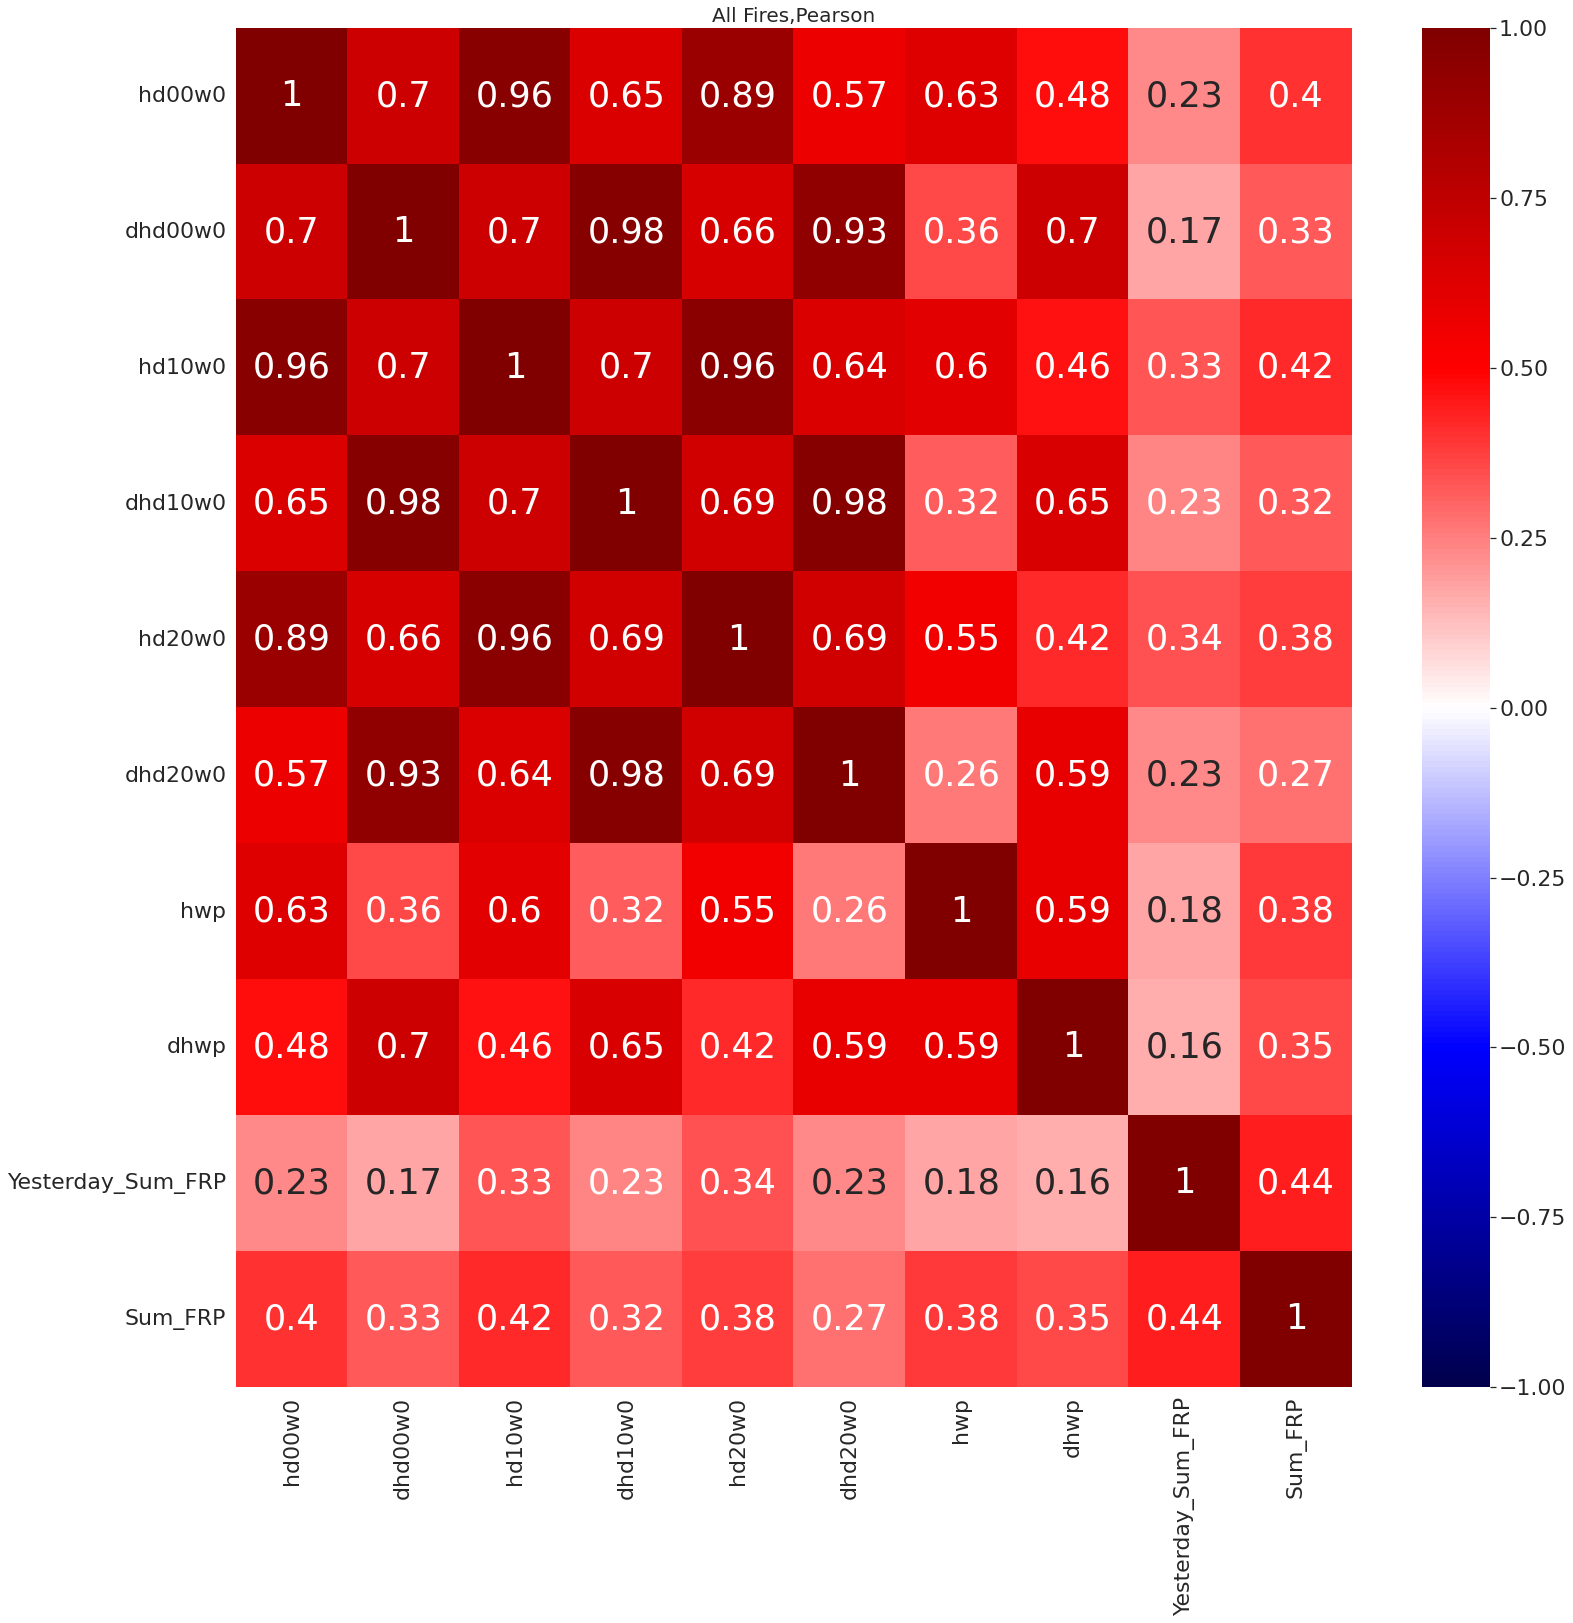

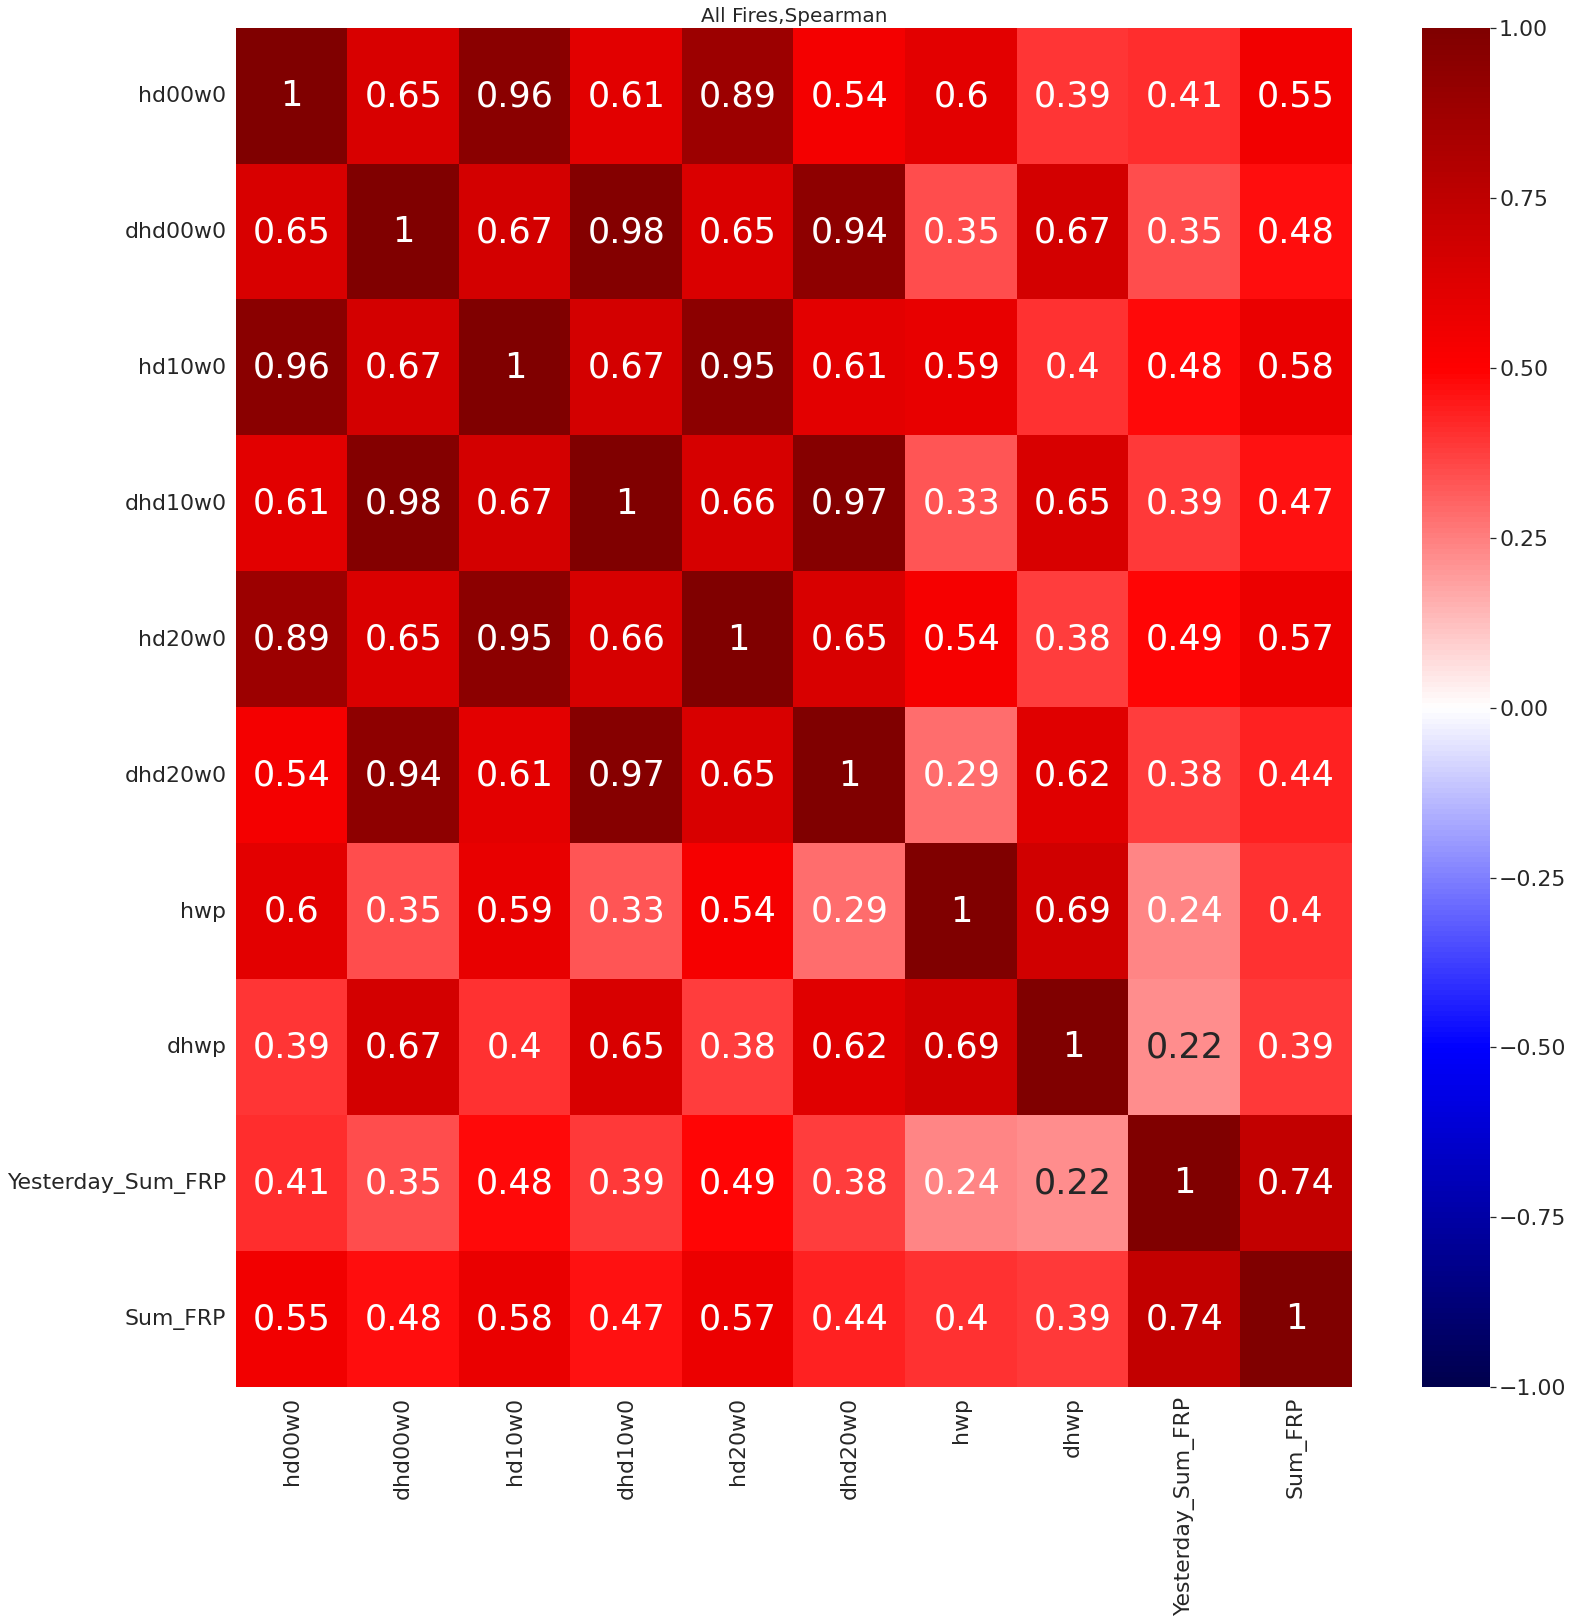

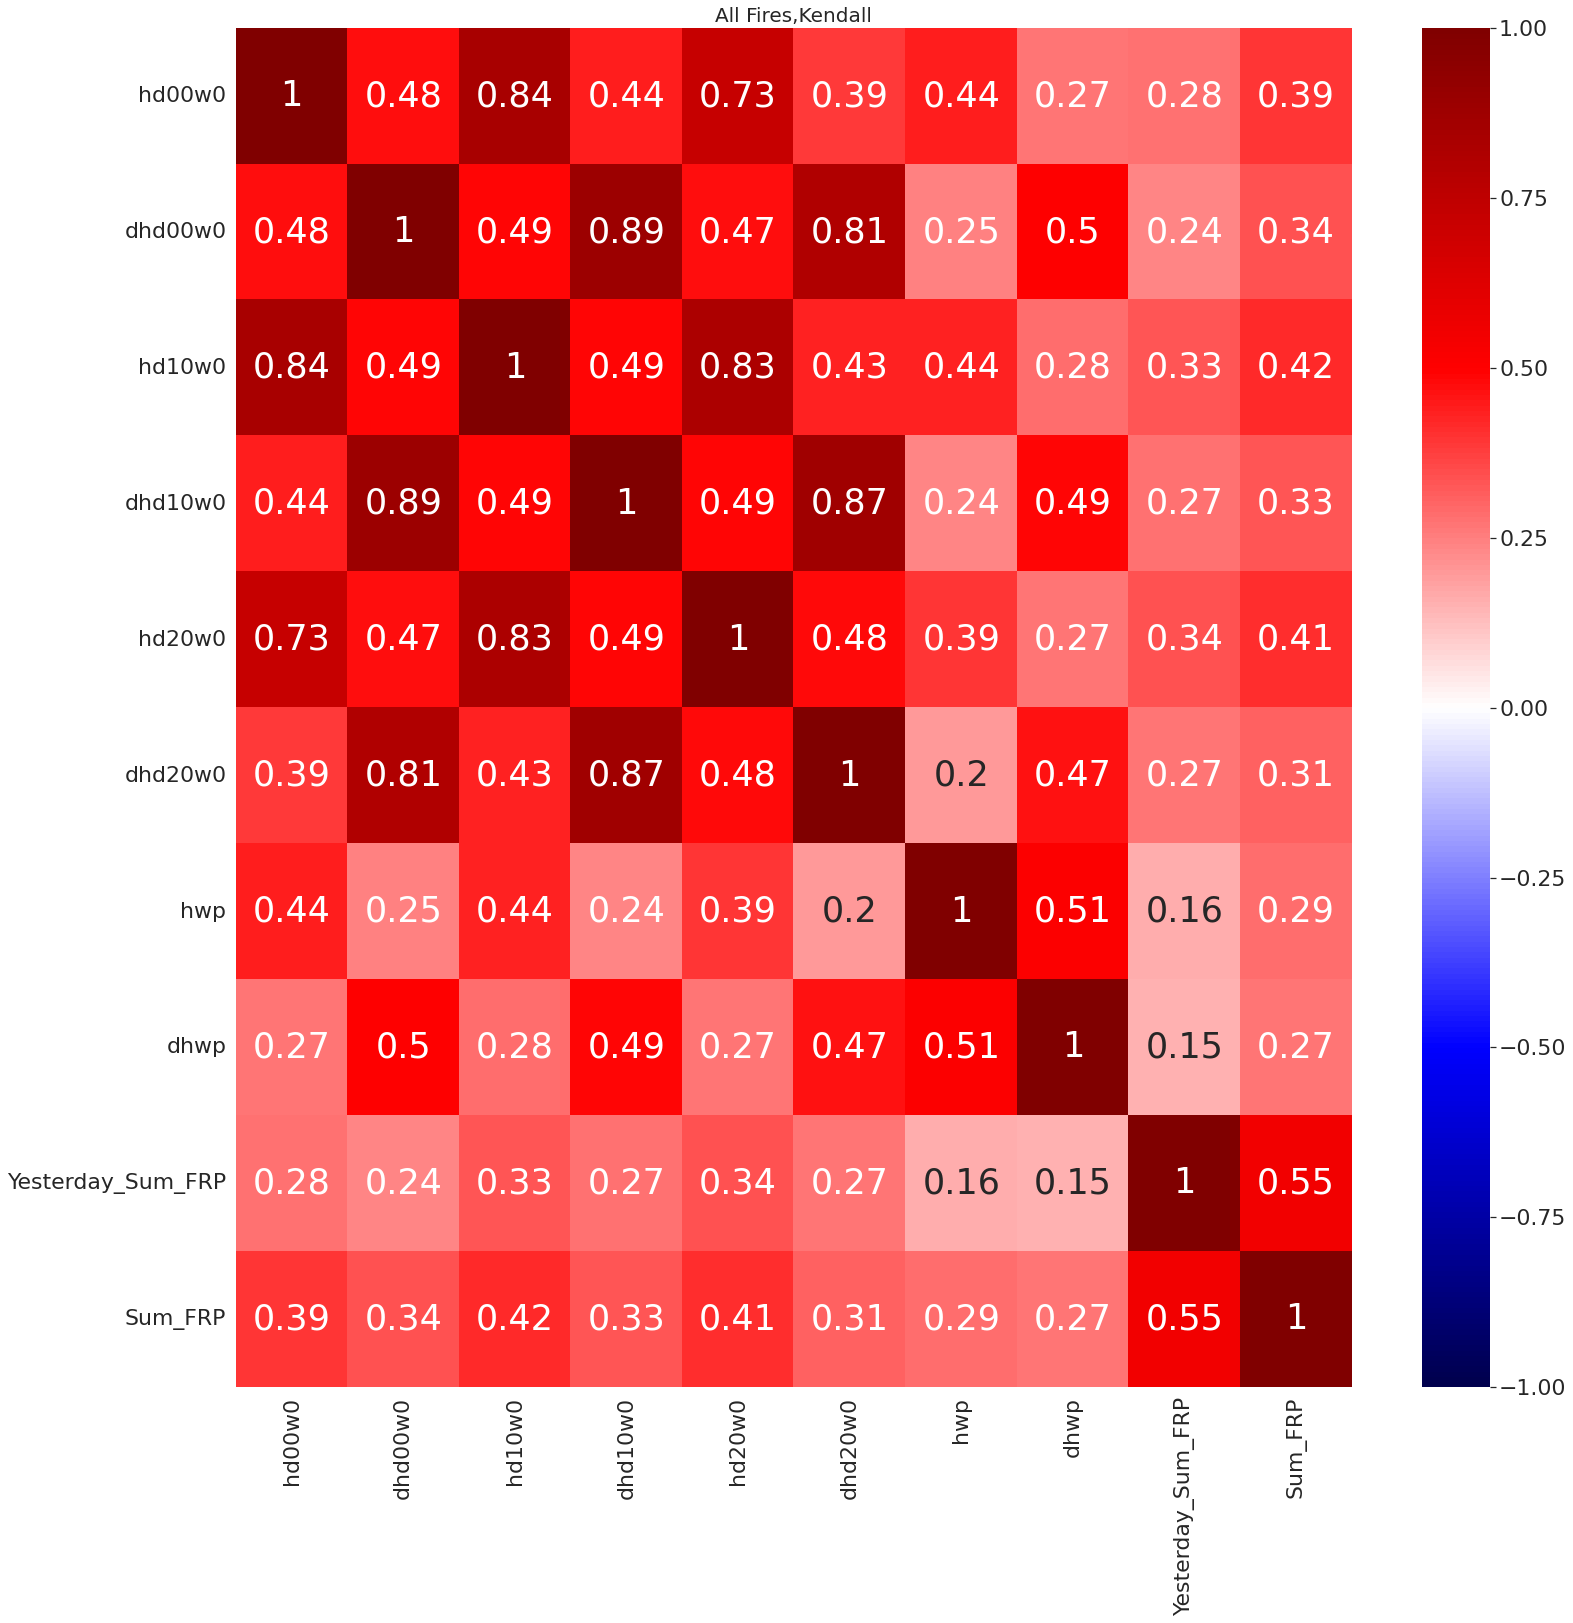

In [8]:
#check just the indices
plot_correlations(features_all[['hd00w0','dhd00w0','hd10w0','dhd10w0','hd20w0','dhd20w0',
                                'hwp','dhwp','Yesterday_Sum_FRP','Sum_FRP']], 'All Fires,Pearson','pearson')
plot_correlations(features_all[['hd00w0','dhd00w0','hd10w0','dhd10w0','hd20w0','dhd20w0',
                                'hwp','dhwp','Yesterday_Sum_FRP','Sum_FRP']], 'All Fires,Spearman','spearman')
plot_correlations(features_all[['hd00w0','dhd00w0','hd10w0','dhd10w0','hd20w0','dhd20w0',
                                'hwp','dhwp','Yesterday_Sum_FRP','Sum_FRP']], 'All Fires,Kendall','kendall')

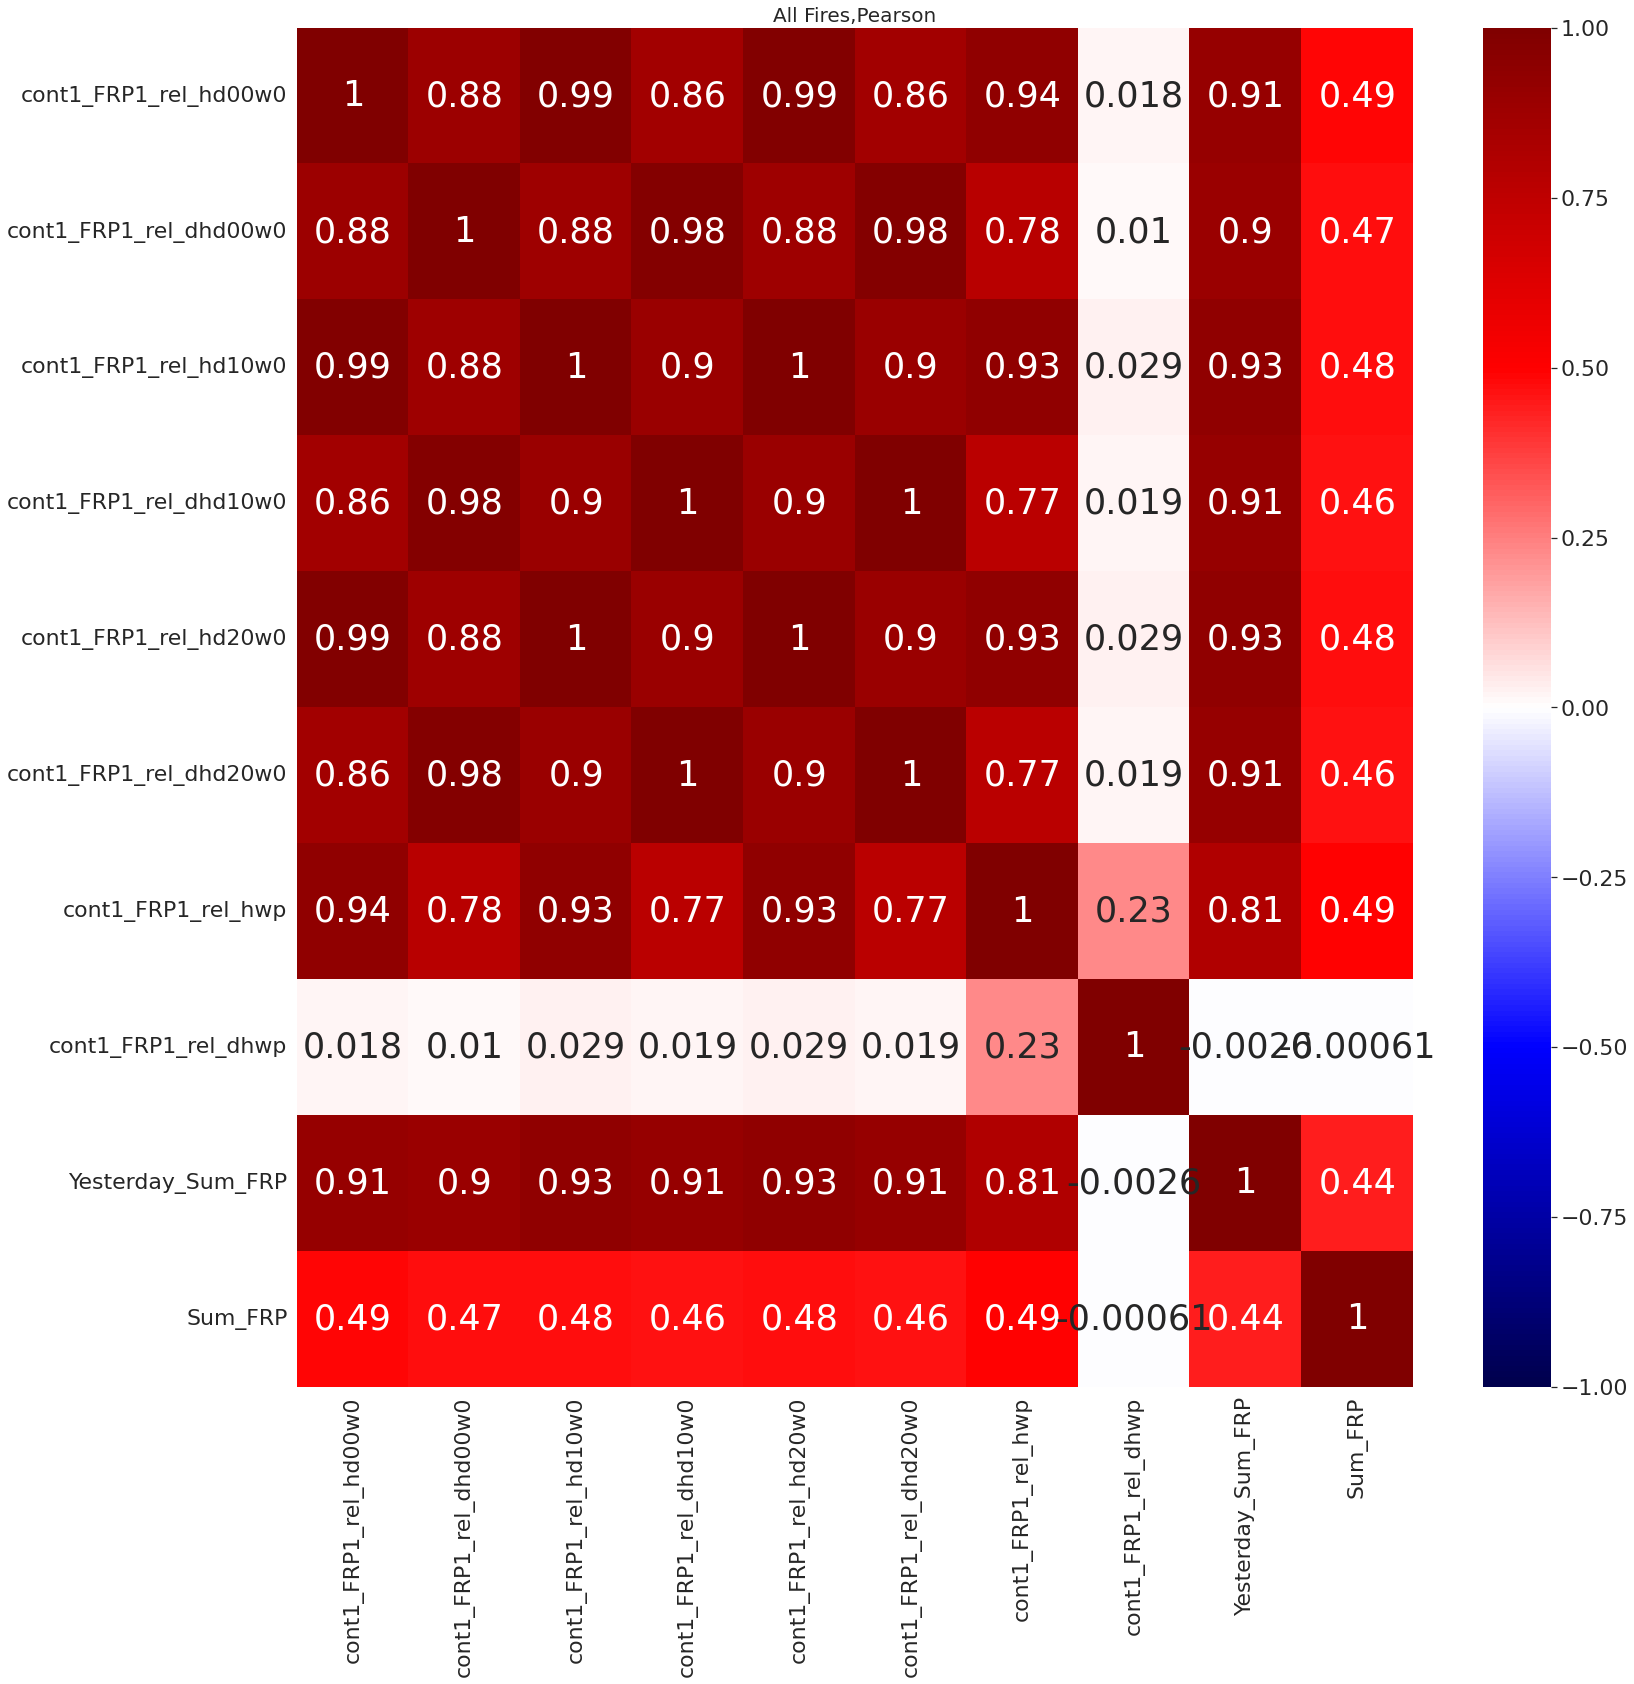

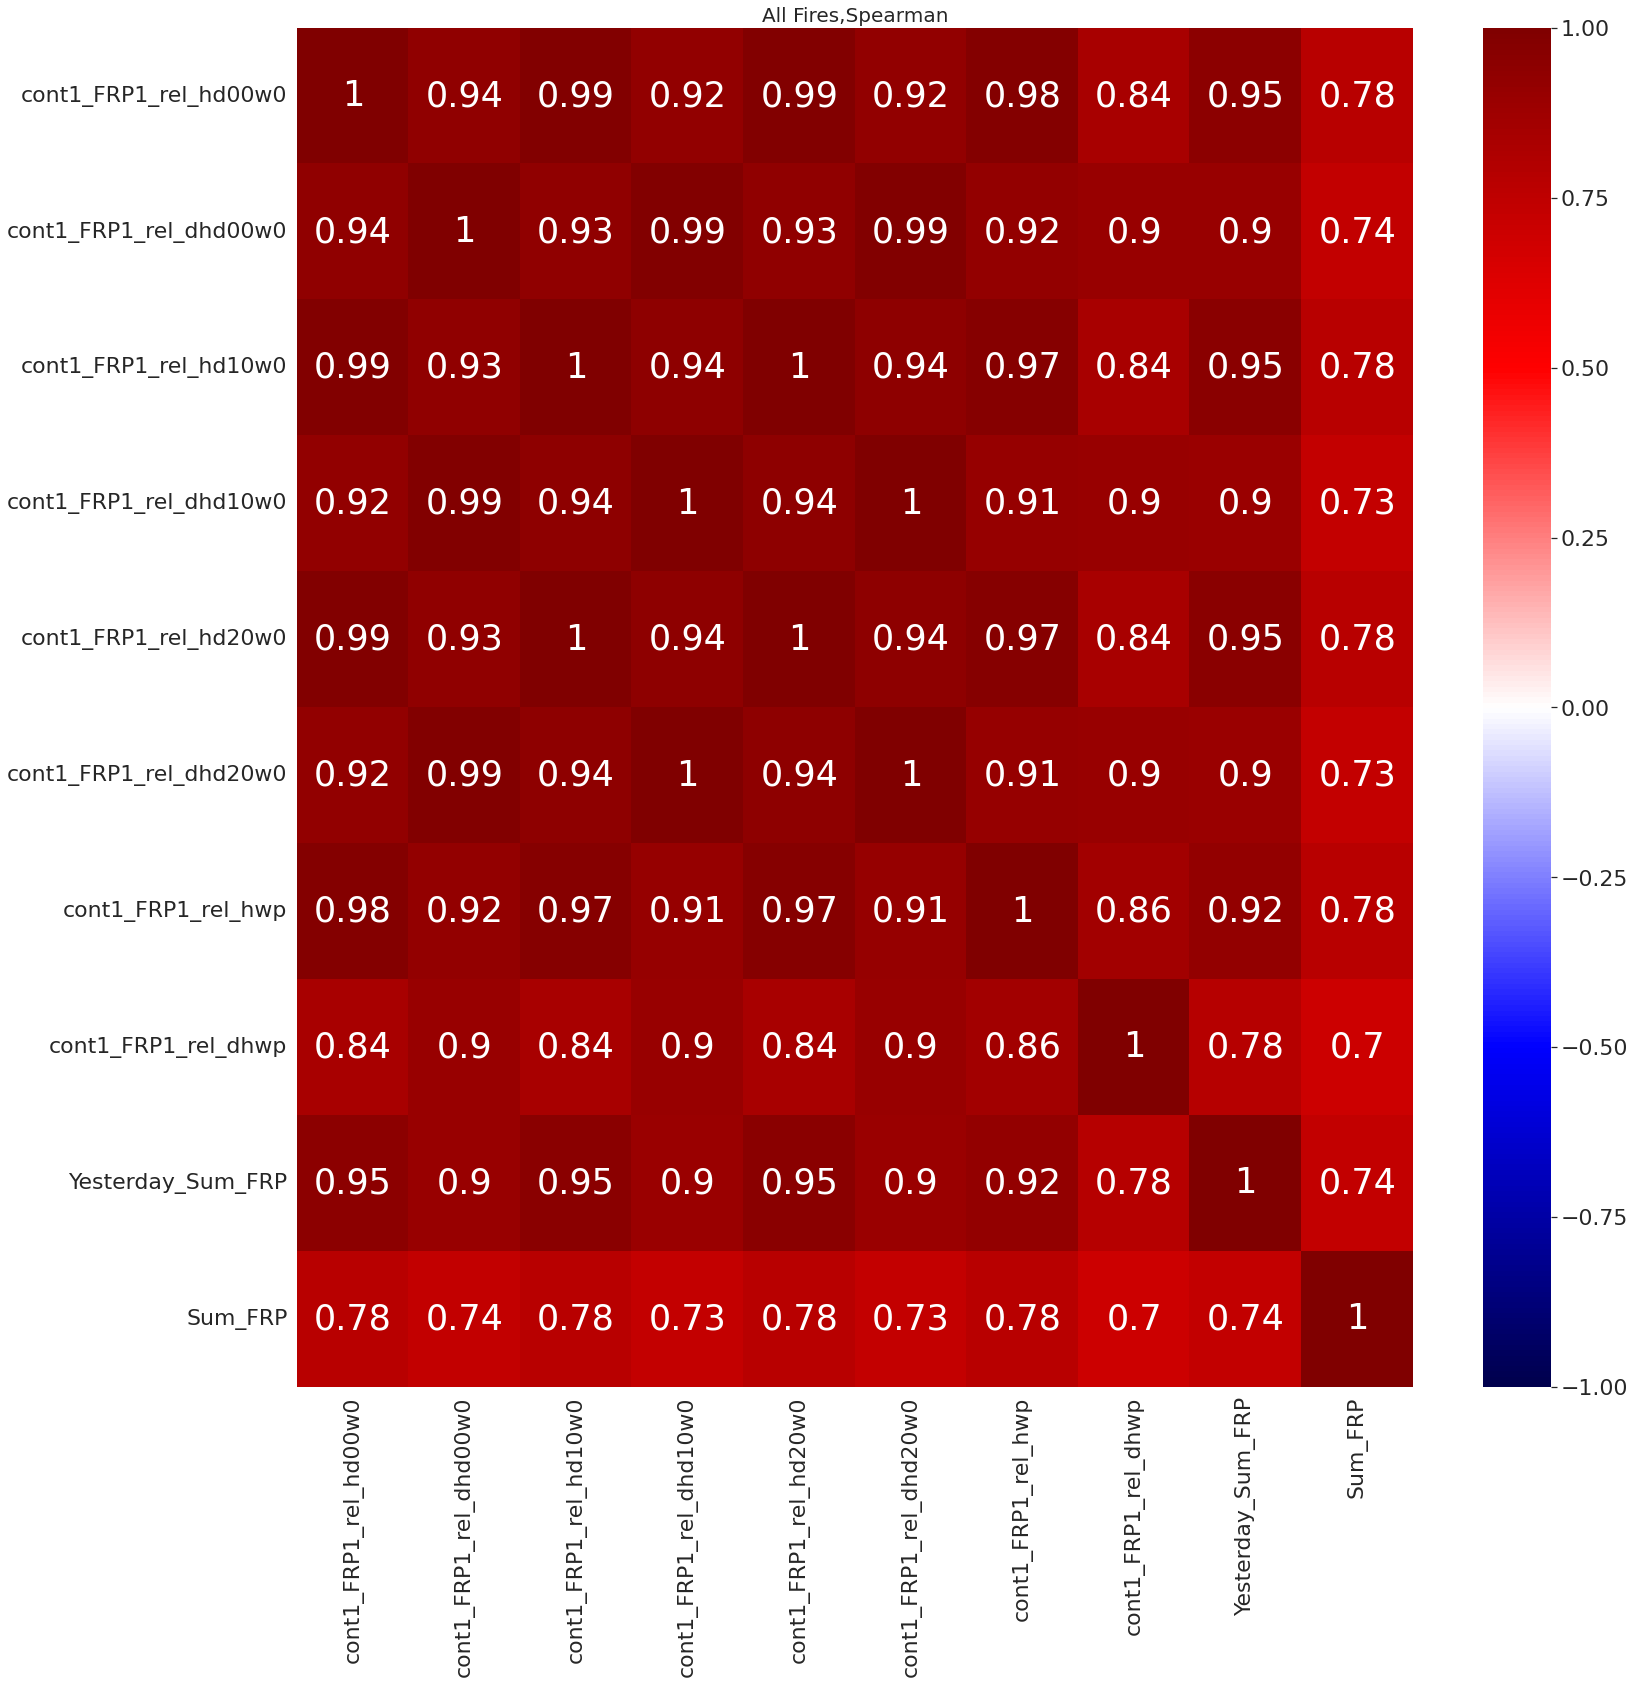

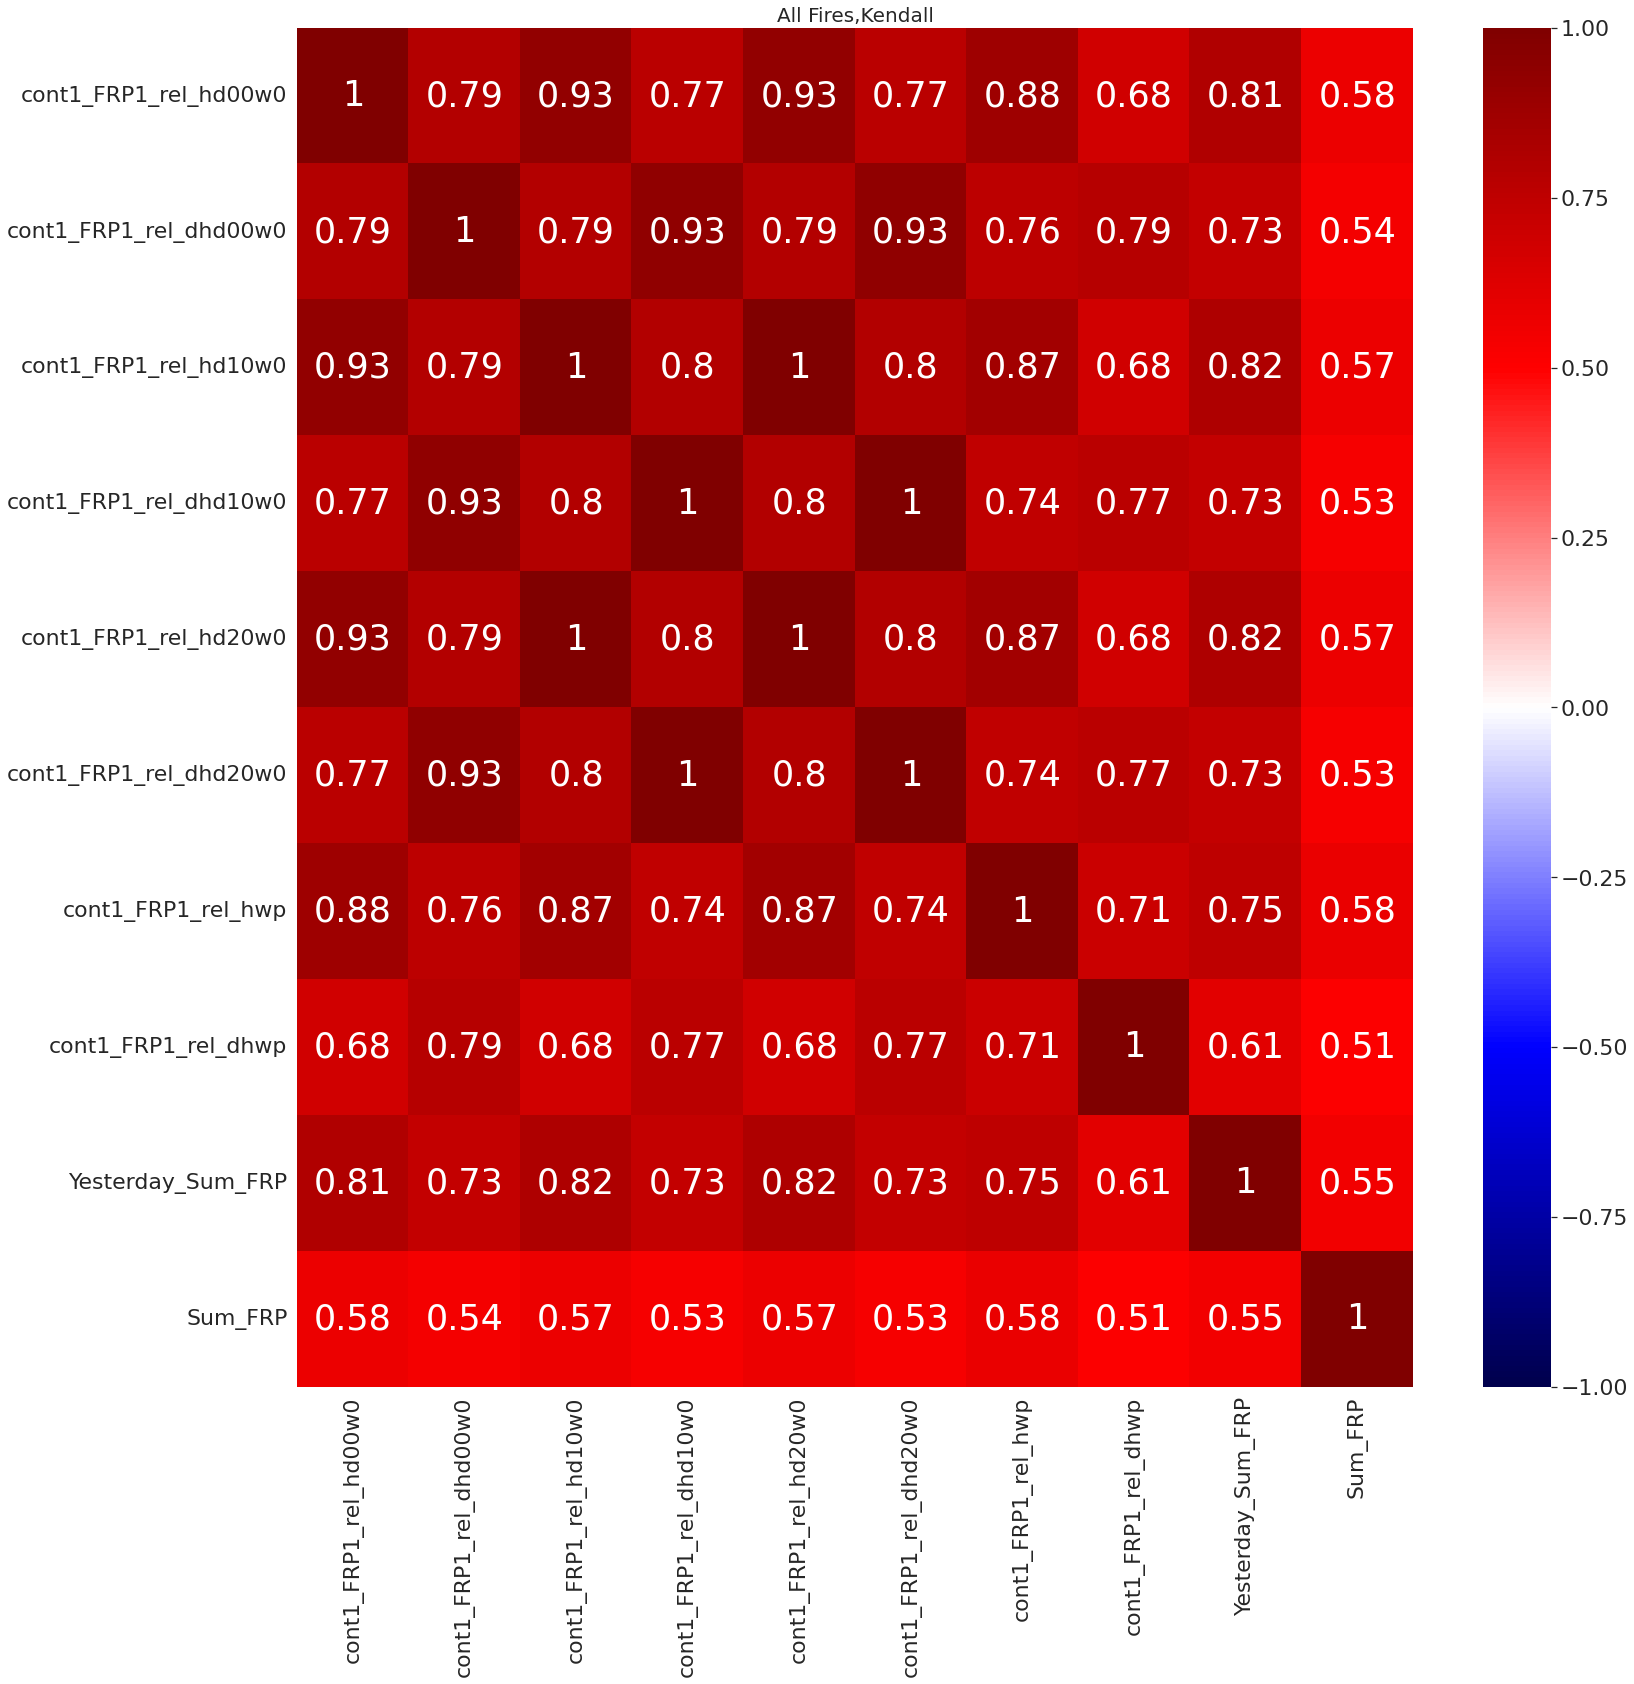

In [9]:
#check the effect of persistence, dropping the outlier timesteps
plot_correlations(feat_cont_pers[['cont1_FRP1_rel_hd00w0','cont1_FRP1_rel_dhd00w0',
                                'cont1_FRP1_rel_hd10w0','cont1_FRP1_rel_dhd10w0',
                                'cont1_FRP1_rel_hd20w0','cont1_FRP1_rel_dhd20w0',
                                'cont1_FRP1_rel_hwp','cont1_FRP1_rel_dhwp','Yesterday_Sum_FRP','Sum_FRP']], 'All Fires,Pearson','pearson')

plot_correlations(feat_cont_pers[['cont1_FRP1_rel_hd00w0','cont1_FRP1_rel_dhd00w0',
                                'cont1_FRP1_rel_hd10w0','cont1_FRP1_rel_dhd10w0',
                                'cont1_FRP1_rel_hd20w0','cont1_FRP1_rel_dhd20w0',
                                'cont1_FRP1_rel_hwp','cont1_FRP1_rel_dhwp','Yesterday_Sum_FRP','Sum_FRP']], 'All Fires,Spearman','spearman')
plot_correlations(feat_cont_pers[['cont1_FRP1_rel_hd00w0','cont1_FRP1_rel_dhd00w0',
                                'cont1_FRP1_rel_hd10w0','cont1_FRP1_rel_dhd10w0',
                                'cont1_FRP1_rel_hd20w0','cont1_FRP1_rel_dhd20w0',
                                'cont1_FRP1_rel_hwp','cont1_FRP1_rel_dhwp','Yesterday_Sum_FRP','Sum_FRP']], 'All Fires,Kendall','kendall')

In [ ]:
plot_correlations(features_all[['hd00w0','dhd00w0','hd10w0','dhd10w0','hd20w0','dhd20w0',
                                'hwp','dhwp','Sum_FRP']], 'All Fires,Pearson','pearson')

AUGUST COMPLEX


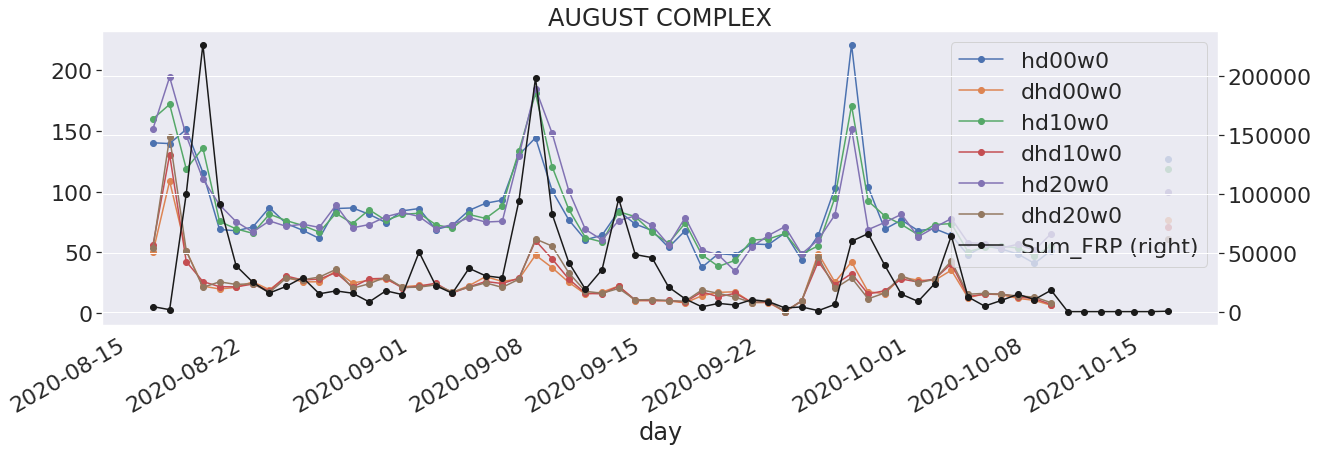

BOBCAT


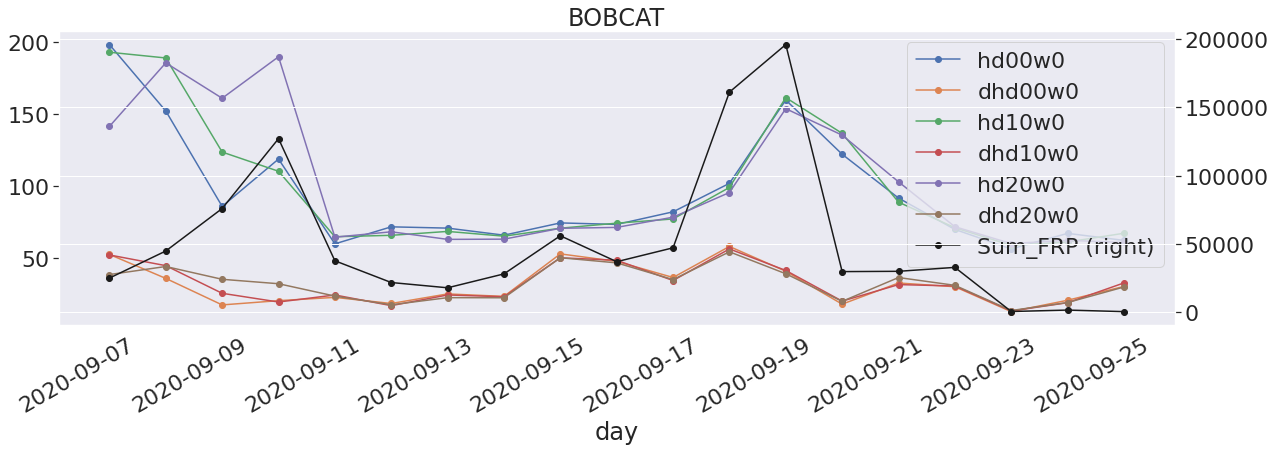

CREEK


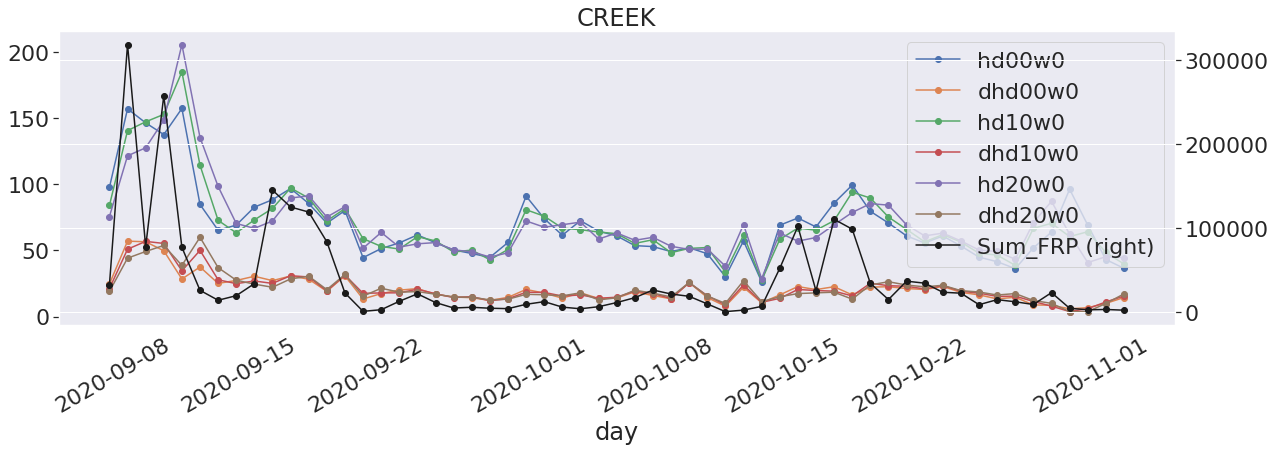

DOLAN


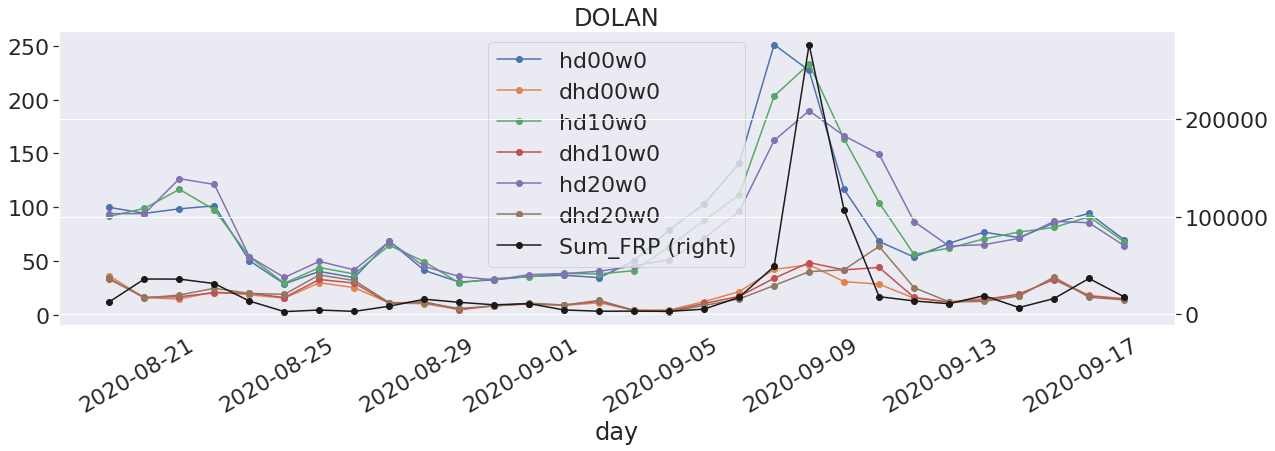

LAKE


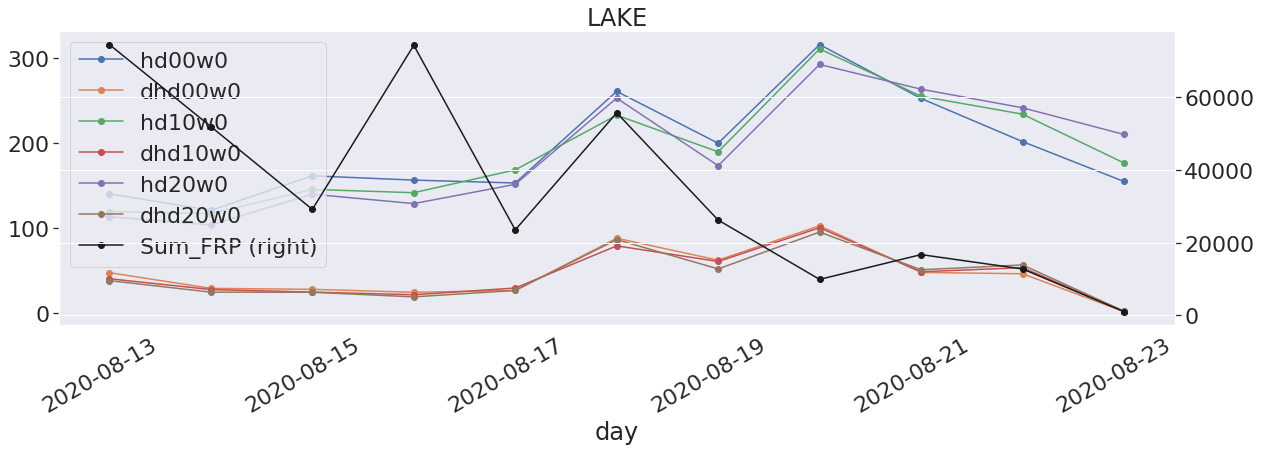

In [10]:
fire_incidents = ['AUGUST COMPLEX', 'BOBCAT','CREEK', 'DOLAN','LAKE'] #only california ones

for ii in range(len(fire_incidents)):
    print(fire_incidents[ii])
    features_plot = features_all[features_all['name']==fire_incidents[ii]]
    fig, ax = plt.subplots(figsize=(20,15)) 
    features_plot.plot(x='day', y=['hd00w0','dhd00w0','hd10w0','dhd10w0','hd20w0','dhd20w0'],
                            figsize=(20,6),style='o-',ax=ax )
    features_plot.plot(x='day', y=['Sum_FRP'], secondary_y=True,
                            figsize=(20,6),style='ko-',ax=ax )
    plt.title(fire_incidents[ii])
    plt.show()

AUGUST COMPLEX


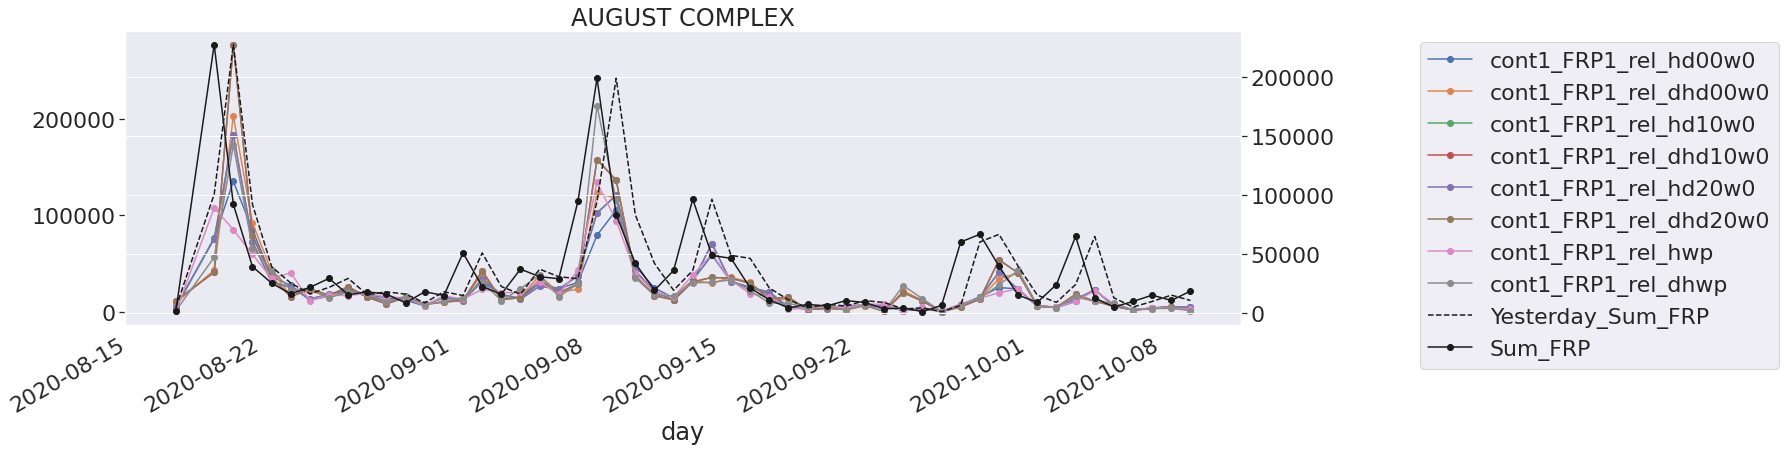

BOBCAT


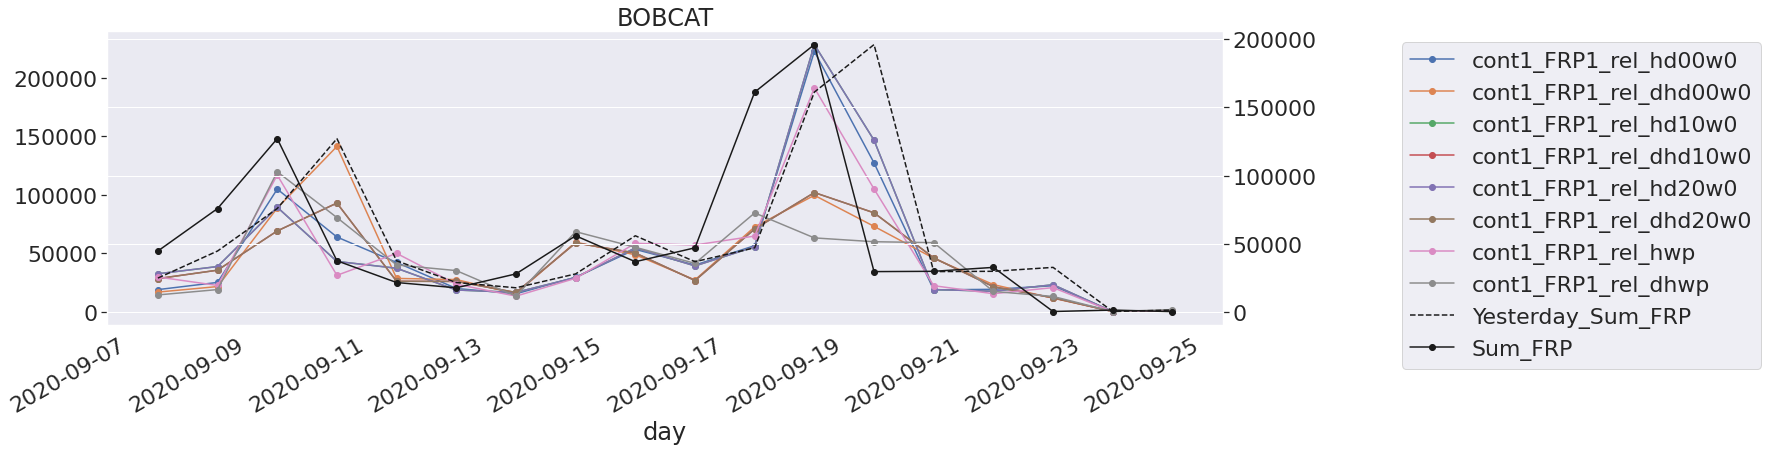

CREEK


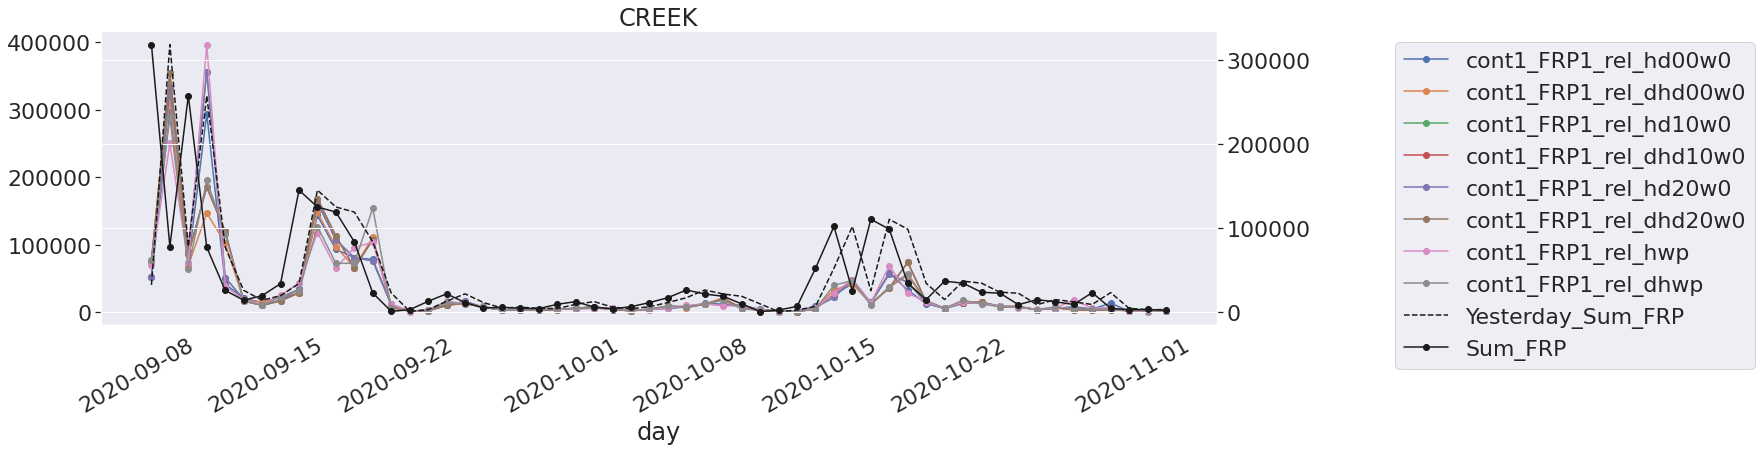

DOLAN


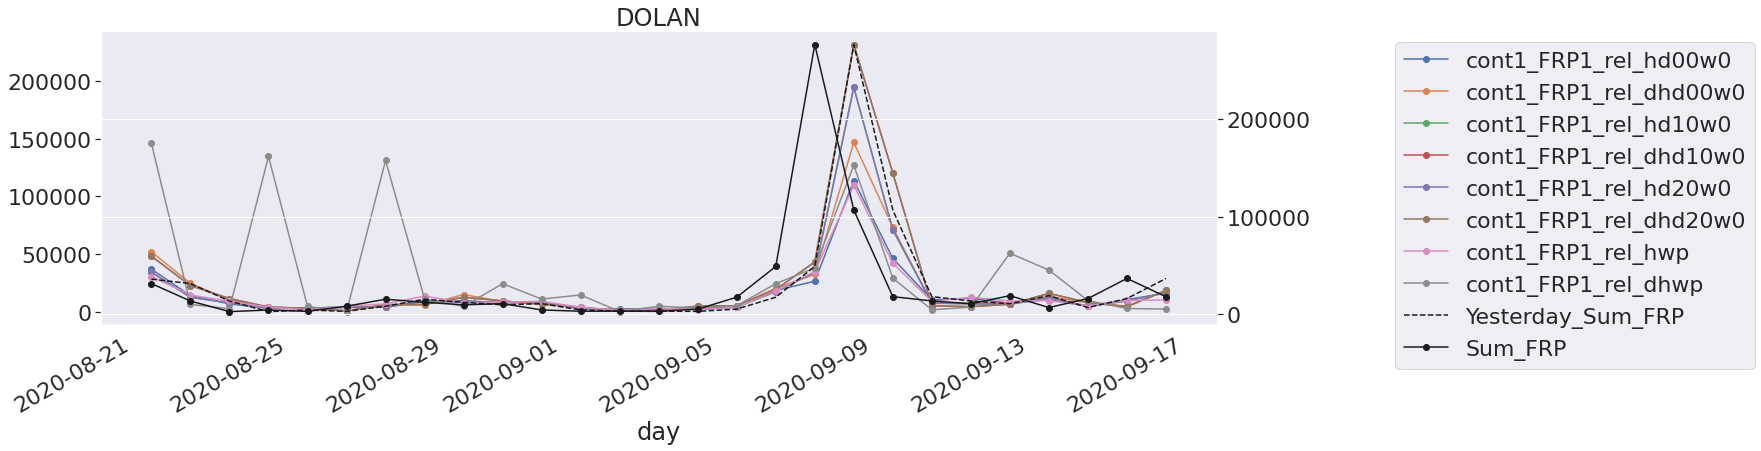

LAKE


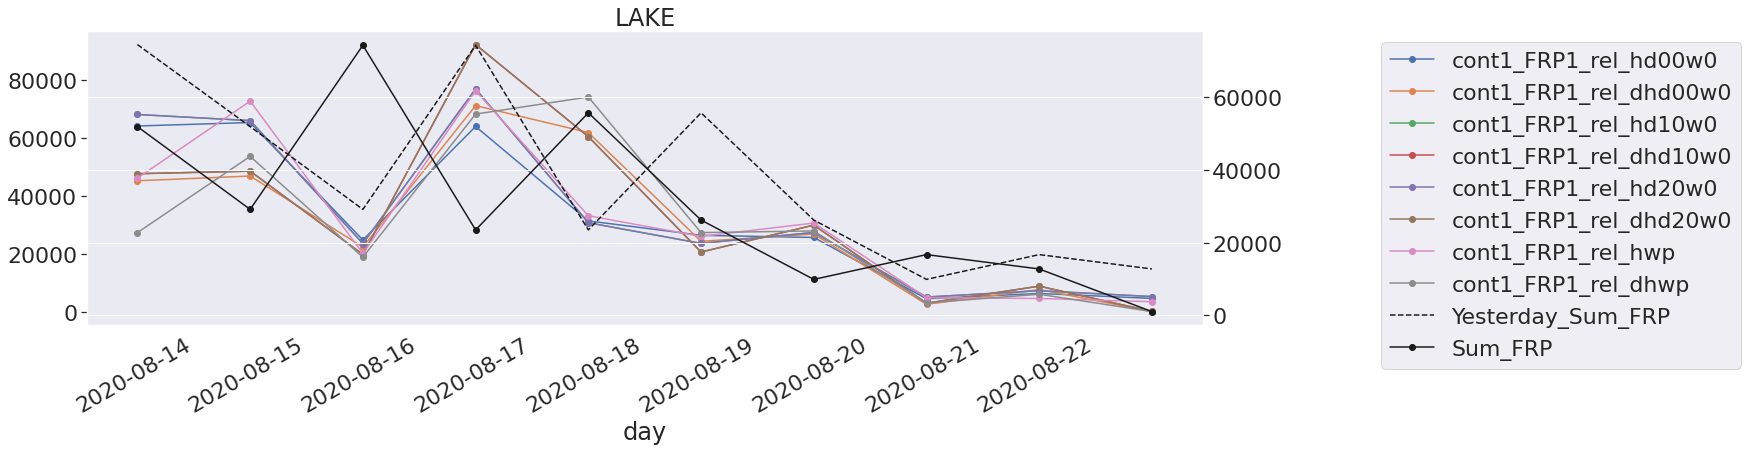

In [17]:
fire_incidents = ['AUGUST COMPLEX', 'BOBCAT','CREEK', 'DOLAN','LAKE'] #only california ones
feat_cont_pers = feat_cont_pers[feat_cont_pers['cont1_FRP1_rel_dhwp']<500000]
for ii in range(len(fire_incidents)):
    print(fire_incidents[ii])
    features_plot = feat_cont_pers[feat_cont_pers['name']==fire_incidents[ii]]
    fig, ax = plt.subplots(figsize=(20,15)) 
    features_plot.plot(x='day', y=['cont1_FRP1_rel_hd00w0','cont1_FRP1_rel_dhd00w0',
                                   'cont1_FRP1_rel_hd10w0','cont1_FRP1_rel_dhd10w0',
                                   'cont1_FRP1_rel_hd20w0','cont1_FRP1_rel_dhd20w0',
                                'cont1_FRP1_rel_hwp','cont1_FRP1_rel_dhwp'],
                            figsize=(20,6),style='o-',ax=ax )
    features_plot.plot(x='day', y=['Yesterday_Sum_FRP','Sum_FRP'], secondary_y=True,
                            figsize=(20,6),style=['k--','ko-'],ax=ax )
    h1, l1 = ax.get_legend_handles_labels()
    h2, l2 = ax.right_ax.get_legend_handles_labels()
    ax.legend(h1+h2, l1+l2,bbox_to_anchor=(1.15, 1), loc='upper left')

    plt.title(fire_incidents[ii])
    plt.show()